# Sentiment Analysis for Financial News

The goal of this project is to do a supervised Sentiment Analysis on Financial Newspaper's Headlines, using a Neural Network built with Pytorch.

In [1]:
import pandas as pd
import numpy as np

# graphs
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()
sns.set_context("paper")

# cleaning
import unidecode

# stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# vocab
from collections import Counter

# models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from tqdm import tqdm  


[nltk_data] Downloading package stopwords to C:\Users\Camille
[nltk_data]     Leempoels\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\Camille Leempoels\.conda\envs\finance\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


## Introduction

### Sentiment analysis

Sentiment Analysis is a method used Natural Language Processing. As the name suggests, the goal is generally to determine whether a given text expresses positive, negative, or neutral sentiment. This tool has a wide range of applications : social network monitoring, customer feedback, trading signal, and many others. 

To perform sentiment analysis, it is generally necessary to perform supervised learning on a large quantity of texts that have been previously labeled by a sentiment. Many models can be used to obtain convincing results, we will focus here on two types of neural networks: RNN and LSTM.

### Dataset

The dataset used in this project comes from kaggle (https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news). It contains 4846 headlines classified in three 

In [3]:
data = pd.read_csv('data.csv', encoding='latin-1', names=['sentiment','text'])

In [4]:
data.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


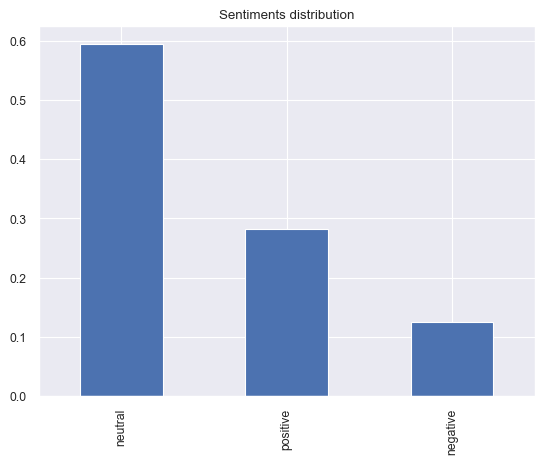

In [5]:
(data.sentiment.value_counts() / data.shape[0]).plot.bar();
plt.title('Sentiments distribution');

Cleaning the text.

In [6]:
# Removing punctuation and special caracters
data['text'] = data['text'].str.replace('[^\w\s]', '', regex=True)
data['text'] = data['text'].str.replace('_', ' ')
data['text'] = data['text'].astype('unicode')
data['text'] = data['text'].transform(lambda x: unidecode.unidecode(x))

# Lowercase the text
data['text'] = data['text'].str.lower()

# Removing numbers
data['text'] = data['text'].str.replace('\d+', '', regex=True)

# Removing stop words
nltk_stopwords = stopwords.words('english')
data['text'] = data['text'].apply(lambda x: [item for item in x.split() if item not in nltk_stopwords])

# Lemmatization and/or Expand Contractions ?

Split train and test set

In [7]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=1)
test_set, validation_set = train_test_split(test_set, test_size=0.5, random_state=2)

Building the vocabulary from the training set

In [8]:
# extract all the words and count them
vocab = Counter([word for sentence in train_set['text'].values.tolist() for word in sentence])

print('Number of words in the training set : ' + str(sum(vocab.values())))
print('Number of unique words in the training set : ' + str(len(list(vocab))))

# Sort the words
vocab = vocab.most_common()

print('Most frequent words : ' + str(vocab[0:10]))

# convert the vocabulary to a Python Dict
vocab = dict(vocab)

# encode words as integers
sparse_vocab = {word:i for i, word in enumerate(vocab, 1)} 
inv_sparse_vocab = {v: k for k, v in sparse_vocab.items()}

unknown = len(list(vocab)) + 1

Number of words in the training set : 46400
Number of unique words in the training set : 8337
Most frequent words : [('eur', 1057), ('company', 680), ('mn', 475), ('said', 437), ('finnish', 405), ('sales', 354), ('million', 335), ('profit', 325), ('net', 323), ('finland', 278)]


Distribution of the length of the sentences

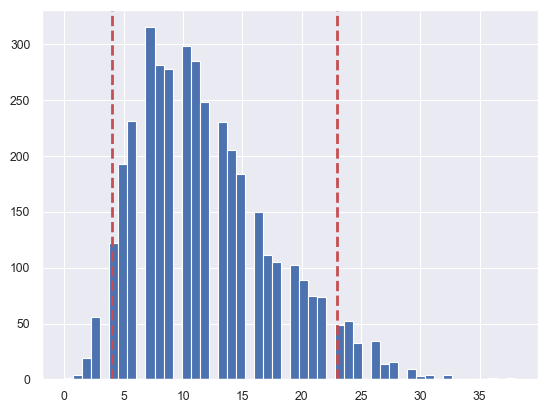

In [9]:
length = train_set['text'].apply(lambda sentence : len(sentence))
limit_low, limit_high  = length.quantile(q=[0.05, 0.95]).values
length.hist(bins=50);
plt.axvline(limit_low, color='r', linewidth=2, linestyle="dashed");
plt.axvline(limit_high, color='r', linewidth=2, linestyle="dashed");

Encode the text and labels

In [10]:
def encode_text(data, limit_low = limit_low, limit_high = limit_high):
    # encode sentences and set -1 if the word is not in the vocabulary
    data['text_encoded'] = data['text'].apply(
        lambda sentence : [sparse_vocab.get(word, unknown) for word in sentence]
    )

    # drop sentences that are extremely short or long
    data['length'] = data['text_encoded'].apply(lambda sentence : len(sentence))
    data = data[(data['length'] <= limit_high) & (data['length'] >= limit_low)].copy()

    # pad sentences so that each vector has the same length
    max_len = int(limit_high)
    data['text_encoded'] = data.apply(lambda row: [0] * (max_len - row['length']) + row['text_encoded'], axis=1)
    data['length'] = data['text_encoded'].apply(lambda sentence : len(sentence))

    if sum(data['length'] != max_len):
        print('WARNING')

    return data

def decode(data):
    for encoded_sentence in data:
        print([inv_sparse_vocab.get(number, '') for number in encoded_sentence])

Store the encoded data as Tensors.

In [11]:
def format_tensors(set):
    txt = encode_text(set.copy())
    labels = txt['sentiment'].replace(['positive','neutral','negative'], [0, 1, 2])

    return torch.tensor(np.vstack(txt['text_encoded'])), torch.tensor(np.vstack(labels)).long()#.to(device)

train_txt, train_labels = format_tensors(train_set)
val_txt, val_labels = format_tensors(validation_set)
test_txt, test_labels = format_tensors(test_set)

validation_dataloader = DataLoader(
    TensorDataset(val_txt, val_labels), 
    batch_size = len(val_labels)
)

test_dataloader = DataLoader(
    TensorDataset(test_txt, test_labels), 
    batch_size = len(test_labels)
)

## Reccurent Neural Network

Initialize a RNN module with Pytorch.

In [12]:
class RNN_module(nn.Module):

    def __init__(self, vocab_dim, embedding_dim, hidden_dim):
        super().__init__()

        # embedding layer
        self.embedding_layer = nn.Embedding(vocab_dim, embedding_dim, padding_idx=0)
        # RNN layer
        self.rnn_layer = nn.RNN(embedding_dim, hidden_dim)
        # fully connected layer
        self.fc_layer = nn.Linear(hidden_dim, 3)

    def forward(self, txt):
        emb_txt = self.embedding_layer(txt.T)
        rnn_out, rnn_hidden = self.rnn_layer(emb_txt)
        fc_out = self.fc_layer(rnn_hidden.squeeze(0))
        return fc_out

Wrap the RNN module with Skorch.

In [13]:
from skorch import NeuralNetClassifier

rnn_net = NeuralNetClassifier(
    RNN_module,
    criterion = nn.CrossEntropyLoss(),
    optimizer = torch.optim.SGD,
    device = 'cuda',
    module__vocab_dim = len(vocab) + 2,
    module__embedding_dim = 50,
    module__hidden_dim = 32
)

Finetune the hyperparameters with GridSearch

In [43]:
param_grid = {
    'batch_size' : [16, 32],
    'max_epochs' : [10, 50, 100],
    'lr' : [1e-2, 1e-3],
    'module__embedding_dim' : [10, 50, 100],
    'module__hidden_dim' : [10, 50, 100]
}

grid = GridSearchCV(
    estimator=rnn_net, 
    param_grid=param_grid,
    n_jobs=-1,
    cv=10
)

# cv_res = grid.fit(train_txt, train_labels.squeeze())
# print("Best: %f using %s" % (cv_res.best_score_, cv_res.best_params_))
# print(cv_res.best_estimator_)
# pd.DataFrame(cv_res.cv_results_).to_csv('cv_res.csv', index = False)
cv_res_df = pd.read_csv('cv_res.csv')

Best: 0.625667 using {'batch_size': 16, 'lr': 0.001, 'max_epochs': 50, 'module__embedding_dim': 50, 'module__hidden_dim': 100}
<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=RNN_module(
    (embedding): Embedding(8338, 50, padding_idx=0)
    (rnn): RNN(50, 100)
    (fc): Linear(in_features=100, out_features=3, bias=True)
  ),
)


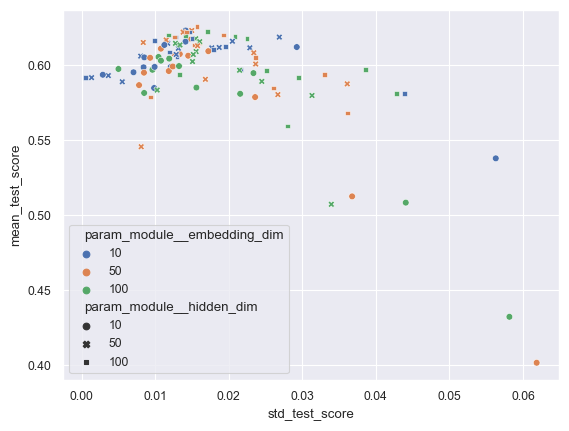

In [44]:
sns.scatterplot(
    data=cv_res_df, 
    y='mean_test_score', 
    x='std_test_score', 
    hue='param_module__embedding_dim', 
    style='param_module__hidden_dim', 
    palette="deep"
);

The gridsearch only looks at the best average test score, it doesn't take into account the standard deviation. By plotting the results, we can see that the parameters EMBEDDING_DIM = 50 and HIDDEN_DIM = 50 seem lead to a good compromise between mean and standard deviation.

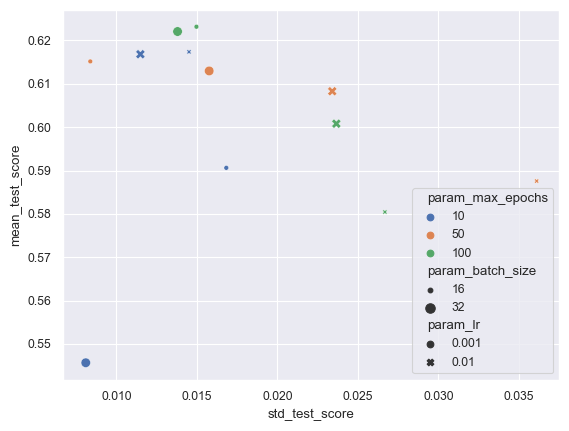

In [53]:
sns.scatterplot(
    data=cv_res_df.query('param_module__embedding_dim == 50 and param_module__hidden_dim == 50'), 
    y='mean_test_score', 
    x='std_test_score', 
    hue='param_max_epochs', 
    style='param_lr', 
    size='param_batch_size',
    palette="deep"
);

We will keep MAX_EPOCHS = 100, BATCH_SIZE = 32 and LR = 0.001.

Train and evaluate the model.

In [42]:
def train_epoch(dataloader, model, optimizer, loss_function):
    
    model.train()
    
    for txt, label in dataloader:

        # forward computation
        pred = model(txt)
        loss = loss_function(pred, label.squeeze())

        # backward computation
        optimizer.zero_grad()  
        loss.backward()
        optimizer.step()

In [15]:
def eval_epoch(dataset, model, loss_function, accuracy_function):
    
    model.eval()
    loss = []
    acc = []
    
    with torch.no_grad():

        for txt, label in dataset:

            pred = model(txt)
            loss.append(loss_function(pred, label.squeeze()).item())
            acc.append(accuracy_function(pred, label).item())
        
    return np.mean(loss), np.mean(acc)

In [43]:
def train_and_validate_model(model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, verbose = False, **kwargs):
    
    # Balance the labels
    labels_counts = torch.bincount(train_labels.squeeze())
    print(labels_counts)
    train_size = int(len(train_labels))
    labels_weights = [train_size/labels_counts[i] for i in range(3)]
    weights = [labels_weights[train_labels[i]] for i in range(train_size)]
    sampler = WeightedRandomSampler(torch.DoubleTensor(weights), train_size)

    train_dataloader = DataLoader(
        TensorDataset(train_txt, train_labels), 
        batch_size = BATCH_SIZE,
        sampler = sampler
        # shuffle=True
    )

    loss_function = nn.CrossEntropyLoss()
    accuracy_function = lambda pred, target : torch.sum((torch.argmax(torch.softmax(pred, dim=1), dim=1) == target.T)) / len(target)
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

    train_loss_array = []
    train_accuracy_array = []
    val_loss_array = []
    val_accuracy_array = []

    for epoch in tqdm(range(EPOCHS)):
        # training
        train_epoch(train_dataloader, model, optimizer, loss_function)

        # compute loss and accuracy metrics
        train_loss, train_accuracy = eval_epoch(train_dataloader, model, loss_function, accuracy_function)
        val_loss, val_accuracy = eval_epoch(validation_dataloader, model, loss_function, accuracy_function)

        train_loss_array.append(train_loss)
        train_accuracy_array.append(train_accuracy)
        val_loss_array.append(val_loss)
        val_accuracy_array.append(val_accuracy)

        if verbose:
            print('EPOCH : ' + str(epoch + 1))
            print('Training loss : ' + str(train_loss) + ' | Training accuracy : ' + str(train_accuracy))
            print('Validation loss : ' + str(val_loss) + ' | Validation accuracy : ' + str(val_accuracy))

    fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout = True, figsize = (10,10))

    sns.lineplot(x=range(EPOCHS), y=train_loss_array, ax=ax1, label='Training set')
    sns.lineplot(x=range(EPOCHS), y=val_loss_array, ax=ax1, label='Validation set')
    ax1.set_xlabel('Epochs')
    ax1.set_title('Loss')
    ax1.legend();

    sns.lineplot(x=range(EPOCHS), y=train_accuracy_array, ax=ax2, label='Training set')
    sns.lineplot(x=range(EPOCHS), y=val_accuracy_array, ax=ax2, label='Validation set')
    ax2.set_xlabel('Epochs')
    ax2.set_title('Accuracy')
    ax2.legend();

    title = 'RNN | Batch size : ' + str(BATCH_SIZE) + ' | LR : ' + str(LEARNING_RATE) + ' | Embedding : ' + str(EMBEDDING_DIM) + ' | Hidden : ' + str(HIDDEN_DIM) 
    for key, value in kwargs.items():
        title = title + ' | ' + str(value)

    fig.suptitle(title);

    return("Test set accuracy: %f" % eval_epoch(test_dataloader, model, loss_function, accuracy_function)[1])

tensor([1017, 2145,  463])


  1%|          | 1/100 [00:00<01:17,  1.28it/s]

EPOCH : 1
Training loss : 1.0942101426291884 | Training accuracy : 0.356725146373113
Validation loss : 1.115456223487854 | Validation accuracy : 0.32244008779525757


  2%|▏         | 2/100 [00:01<01:10,  1.40it/s]

EPOCH : 2
Training loss : 1.0750572681427002 | Training accuracy : 0.39738669599357407
Validation loss : 1.089563250541687 | Validation accuracy : 0.3616557717323303


  3%|▎         | 3/100 [00:02<01:04,  1.50it/s]

EPOCH : 3
Training loss : 1.0647200900211669 | Training accuracy : 0.4187682749409425
Validation loss : 1.068772315979004 | Validation accuracy : 0.3965141475200653


  4%|▍         | 4/100 [00:02<01:00,  1.59it/s]

EPOCH : 4
Training loss : 1.0467518003363359 | Training accuracy : 0.4356420565592615
Validation loss : 1.0532119274139404 | Validation accuracy : 0.44008713960647583


  5%|▌         | 5/100 [00:03<00:59,  1.59it/s]

EPOCH : 5
Training loss : 1.0381521446663036 | Training accuracy : 0.4475816279126887
Validation loss : 1.0465521812438965 | Validation accuracy : 0.46840959787368774


  6%|▌         | 6/100 [00:03<00:57,  1.63it/s]

EPOCH : 6
Training loss : 1.0279932863879622 | Training accuracy : 0.4579373781749031
Validation loss : 1.0368064641952515 | Validation accuracy : 0.4749455451965332


  7%|▋         | 7/100 [00:04<00:56,  1.65it/s]

EPOCH : 7
Training loss : 1.0177963475386302 | Training accuracy : 0.46427266090585473
Validation loss : 1.0263639688491821 | Validation accuracy : 0.48366013169288635


  8%|▊         | 8/100 [00:05<00:54,  1.68it/s]

EPOCH : 8
Training loss : 1.0228586693604786 | Training accuracy : 0.4552266082742758
Validation loss : 1.0296666622161865 | Validation accuracy : 0.4727668762207031


  9%|▉         | 9/100 [00:05<00:58,  1.56it/s]

EPOCH : 9
Training loss : 1.014627321247469 | Training accuracy : 0.47191764133279784
Validation loss : 1.0194653272628784 | Validation accuracy : 0.4793028235435486


 10%|█         | 10/100 [00:06<00:58,  1.54it/s]

EPOCH : 10
Training loss : 1.0112284212781673 | Training accuracy : 0.4703033626602407
Validation loss : 1.0204397439956665 | Validation accuracy : 0.4793028235435486


 11%|█         | 11/100 [00:07<00:58,  1.52it/s]

EPOCH : 11
Training loss : 0.997573350082364 | Training accuracy : 0.47005969808812725
Validation loss : 1.008060336112976 | Validation accuracy : 0.4901960790157318


 12%|█▏        | 12/100 [00:07<00:57,  1.53it/s]

EPOCH : 12
Training loss : 0.9957420235140282 | Training accuracy : 0.4771564328356793
Validation loss : 1.0269688367843628 | Validation accuracy : 0.4749455451965332


 13%|█▎        | 13/100 [00:08<00:54,  1.59it/s]

EPOCH : 13
Training loss : 0.9960005382696787 | Training accuracy : 0.48001949319191145
Validation loss : 1.0085821151733398 | Validation accuracy : 0.5076252818107605


 14%|█▍        | 14/100 [00:08<00:53,  1.62it/s]

EPOCH : 14
Training loss : 0.9813673778584129 | Training accuracy : 0.49156310919084045
Validation loss : 1.0113238096237183 | Validation accuracy : 0.4880174398422241


 15%|█▌        | 15/100 [00:09<00:52,  1.62it/s]

EPOCH : 15
Training loss : 0.9811830515401405 | Training accuracy : 0.4919895226495308
Validation loss : 1.0220017433166504 | Validation accuracy : 0.46405228972435


 16%|█▌        | 16/100 [00:10<00:52,  1.61it/s]

EPOCH : 16
Training loss : 0.9674918437213228 | Training accuracy : 0.50995979549592
Validation loss : 1.0456511974334717 | Validation accuracy : 0.45098039507865906


 17%|█▋        | 17/100 [00:10<00:50,  1.65it/s]

EPOCH : 17
Training loss : 0.9674891364156154 | Training accuracy : 0.50106603325459
Validation loss : 1.0309674739837646 | Validation accuracy : 0.46405228972435


 18%|█▊        | 18/100 [00:11<00:48,  1.68it/s]

EPOCH : 18
Training loss : 0.9598251429566166 | Training accuracy : 0.518305312123215
Validation loss : 1.050034999847412 | Validation accuracy : 0.45315903425216675


 19%|█▉        | 19/100 [00:11<00:47,  1.69it/s]

EPOCH : 19
Training loss : 0.9597491940908265 | Training accuracy : 0.5174829437021624
Validation loss : 1.0263746976852417 | Validation accuracy : 0.46840959787368774


 20%|██        | 20/100 [00:12<00:48,  1.66it/s]

EPOCH : 20
Training loss : 0.9556218929458082 | Training accuracy : 0.5064875731865565
Validation loss : 1.0158525705337524 | Validation accuracy : 0.48148149251937866


 21%|██        | 21/100 [00:13<00:46,  1.69it/s]

EPOCH : 21
Training loss : 0.9435608298109289 | Training accuracy : 0.5220211990046919
Validation loss : 1.0387187004089355 | Validation accuracy : 0.46405228972435


 22%|██▏       | 22/100 [00:13<00:45,  1.70it/s]

EPOCH : 22
Training loss : 0.9424022362943281 | Training accuracy : 0.5357273393555692
Validation loss : 1.0745102167129517 | Validation accuracy : 0.44008713960647583


 23%|██▎       | 23/100 [00:14<00:44,  1.72it/s]

EPOCH : 23
Training loss : 0.9362266000948454 | Training accuracy : 0.5368542885571196
Validation loss : 1.0358799695968628 | Validation accuracy : 0.4771241843700409


 24%|██▍       | 24/100 [00:14<00:45,  1.67it/s]

EPOCH : 24
Training loss : 0.9354770324732128 | Training accuracy : 0.5361232945793554
Validation loss : 1.0798592567443848 | Validation accuracy : 0.44880175590515137


 25%|██▌       | 25/100 [00:15<00:44,  1.68it/s]

EPOCH : 25
Training loss : 0.9347954742741167 | Training accuracy : 0.5313109162083843
Validation loss : 1.057578682899475 | Validation accuracy : 0.4596949815750122


 26%|██▌       | 26/100 [00:16<00:44,  1.68it/s]

EPOCH : 26
Training loss : 0.9208623176081139 | Training accuracy : 0.5508650097538504
Validation loss : 1.0478668212890625 | Validation accuracy : 0.47058823704719543


 27%|██▋       | 27/100 [00:16<00:44,  1.65it/s]

EPOCH : 27
Training loss : 0.9224508017824408 | Training accuracy : 0.5448952244039167
Validation loss : 1.0864759683609009 | Validation accuracy : 0.4444444477558136


 28%|██▊       | 28/100 [00:17<00:45,  1.57it/s]

EPOCH : 28
Training loss : 0.9150626173144892 | Training accuracy : 0.5536976122019583
Validation loss : 1.0780895948410034 | Validation accuracy : 0.4575163424015045


 29%|██▉       | 29/100 [00:18<00:45,  1.56it/s]

EPOCH : 29
Training loss : 0.9203623543705857 | Training accuracy : 0.543524610368829
Validation loss : 1.0693113803863525 | Validation accuracy : 0.4596949815750122


 30%|███       | 30/100 [00:18<00:47,  1.48it/s]

EPOCH : 30
Training loss : 0.9070297903136203 | Training accuracy : 0.5484283626602408
Validation loss : 1.1199498176574707 | Validation accuracy : 0.4117647111415863


 31%|███       | 31/100 [00:19<00:46,  1.49it/s]

EPOCH : 31
Training loss : 0.88869782341154 | Training accuracy : 0.5752010235660955
Validation loss : 1.0710158348083496 | Validation accuracy : 0.44008713960647583


 32%|███▏      | 32/100 [00:20<00:43,  1.56it/s]

EPOCH : 32
Training loss : 0.8999084762313909 | Training accuracy : 0.5530275341711546
Validation loss : 1.0700631141662598 | Validation accuracy : 0.44880175590515137


 33%|███▎      | 33/100 [00:20<00:41,  1.61it/s]

EPOCH : 33
Training loss : 0.876583816189515 | Training accuracy : 0.5642361112853937
Validation loss : 1.1401121616363525 | Validation accuracy : 0.42047929763793945


 34%|███▍      | 34/100 [00:21<00:41,  1.59it/s]

EPOCH : 34
Training loss : 0.8641186874163779 | Training accuracy : 0.5828460039276826
Validation loss : 1.0279755592346191 | Validation accuracy : 0.46840959787368774


 35%|███▌      | 35/100 [00:21<00:43,  1.50it/s]

EPOCH : 35
Training loss : 0.874295422382522 | Training accuracy : 0.5772417156319869
Validation loss : 1.0265086889266968 | Validation accuracy : 0.47058823704719543


 36%|███▌      | 36/100 [00:22<00:43,  1.48it/s]

EPOCH : 36
Training loss : 0.8590364623488042 | Training accuracy : 0.5972526805442676
Validation loss : 1.0351284742355347 | Validation accuracy : 0.4793028235435486


 37%|███▋      | 37/100 [00:23<00:41,  1.50it/s]

EPOCH : 37
Training loss : 0.8528608465403841 | Training accuracy : 0.6052022419477764
Validation loss : 1.178491473197937 | Validation accuracy : 0.413943350315094


 38%|███▊      | 38/100 [00:24<00:42,  1.46it/s]

EPOCH : 38
Training loss : 0.8268147069111205 | Training accuracy : 0.6153447858074255
Validation loss : 1.123017430305481 | Validation accuracy : 0.4466230869293213


 39%|███▉      | 39/100 [00:24<00:40,  1.52it/s]

EPOCH : 39
Training loss : 0.8234839758329224 | Training accuracy : 0.6233248051844145
Validation loss : 1.2008312940597534 | Validation accuracy : 0.38997820019721985


 40%|████      | 40/100 [00:25<00:37,  1.59it/s]

EPOCH : 40
Training loss : 0.8577657514496854 | Training accuracy : 0.571211013877601
Validation loss : 0.9486739635467529 | Validation accuracy : 0.529411792755127


 41%|████      | 41/100 [00:25<00:35,  1.65it/s]

EPOCH : 41
Training loss : 0.8023464841800824 | Training accuracy : 0.6213754875618115
Validation loss : 1.1301451921463013 | Validation accuracy : 0.41830065846443176


 42%|████▏     | 42/100 [00:26<00:35,  1.65it/s]

EPOCH : 42
Training loss : 0.9484489873835915 | Training accuracy : 0.5287524367633619
Validation loss : 0.9519706964492798 | Validation accuracy : 0.5381263494491577


 43%|████▎     | 43/100 [00:26<00:33,  1.68it/s]

EPOCH : 43
Training loss : 0.7730461604762495 | Training accuracy : 0.6434576025134638
Validation loss : 1.1583560705184937 | Validation accuracy : 0.42047929763793945


 44%|████▍     | 44/100 [00:27<00:32,  1.71it/s]

EPOCH : 44
Training loss : 0.7531919751250953 | Training accuracy : 0.6400158384390044
Validation loss : 0.9437446594238281 | Validation accuracy : 0.5337690711021423


 45%|████▌     | 45/100 [00:28<00:32,  1.70it/s]

EPOCH : 45
Training loss : 0.7510355216892142 | Training accuracy : 0.6599049709345165
Validation loss : 1.2628917694091797 | Validation accuracy : 0.3812636137008667


 46%|████▌     | 46/100 [00:28<00:33,  1.61it/s]

EPOCH : 46
Training loss : 0.8865560664419543 | Training accuracy : 0.5707846004189107
Validation loss : 0.9520223736763 | Validation accuracy : 0.5468409657478333


 47%|████▋     | 47/100 [00:29<00:32,  1.63it/s]

EPOCH : 47
Training loss : 0.6848356075454176 | Training accuracy : 0.6933174951557528
Validation loss : 1.1663094758987427 | Validation accuracy : 0.4466230869293213


 48%|████▊     | 48/100 [00:29<00:31,  1.67it/s]

EPOCH : 48
Training loss : 0.6642397040860695 | Training accuracy : 0.6869517543859649
Validation loss : 1.0035933256149292 | Validation accuracy : 0.529411792755127


 49%|████▉     | 49/100 [00:30<00:30,  1.68it/s]

EPOCH : 49
Training loss : 0.6760271230810567 | Training accuracy : 0.6919773393555692
Validation loss : 1.1326931715011597 | Validation accuracy : 0.49673202633857727


 50%|█████     | 50/100 [00:31<00:29,  1.69it/s]

EPOCH : 50
Training loss : 0.6522237525174492 | Training accuracy : 0.695845516627295
Validation loss : 1.278894066810608 | Validation accuracy : 0.43790850043296814


 51%|█████     | 51/100 [00:31<00:29,  1.67it/s]

EPOCH : 51
Training loss : 0.854753608766355 | Training accuracy : 0.5864096004189107
Validation loss : 0.896902859210968 | Validation accuracy : 0.5816993713378906


 52%|█████▏    | 52/100 [00:32<00:28,  1.68it/s]

EPOCH : 52
Training loss : 0.5961991122417283 | Training accuracy : 0.7262426902327621
Validation loss : 1.076667308807373 | Validation accuracy : 0.5054466128349304


 53%|█████▎    | 53/100 [00:33<00:30,  1.56it/s]

EPOCH : 53
Training loss : 0.6629513465521628 | Training accuracy : 0.7007188109452265
Validation loss : 1.2249987125396729 | Validation accuracy : 0.46623092889785767


 54%|█████▍    | 54/100 [00:33<00:29,  1.56it/s]

EPOCH : 54
Training loss : 0.5938720308374941 | Training accuracy : 0.7245979533906568
Validation loss : 1.2806965112686157 | Validation accuracy : 0.4422658085823059


 55%|█████▌    | 55/100 [00:34<00:31,  1.41it/s]

EPOCH : 55
Training loss : 0.559769109152911 | Training accuracy : 0.7630056043465933
Validation loss : 1.0720545053482056 | Validation accuracy : 0.5098039507865906


 56%|█████▌    | 56/100 [00:35<00:30,  1.46it/s]

EPOCH : 56
Training loss : 0.5544759487373787 | Training accuracy : 0.7472283139563444
Validation loss : 1.1023550033569336 | Validation accuracy : 0.5076252818107605


 57%|█████▋    | 57/100 [00:35<00:28,  1.49it/s]

EPOCH : 57
Training loss : 0.5598242714216835 | Training accuracy : 0.7361111112853937
Validation loss : 1.1311067342758179 | Validation accuracy : 0.516339898109436


 58%|█████▊    | 58/100 [00:36<00:27,  1.54it/s]

EPOCH : 58
Training loss : 0.6038290978523723 | Training accuracy : 0.7218567253204814
Validation loss : 1.0894607305526733 | Validation accuracy : 0.5206971764564514


 59%|█████▉    | 59/100 [00:36<00:25,  1.60it/s]

EPOCH : 59
Training loss : 0.5577911737195232 | Training accuracy : 0.7525584797064463
Validation loss : 0.9926871657371521 | Validation accuracy : 0.5446622967720032


 60%|██████    | 60/100 [00:37<00:25,  1.54it/s]

EPOCH : 60
Training loss : 0.5098927295521686 | Training accuracy : 0.7686098929037127
Validation loss : 1.108929991722107 | Validation accuracy : 0.5337690711021423


 61%|██████    | 61/100 [00:38<00:25,  1.53it/s]

EPOCH : 61
Training loss : 0.5462848225183654 | Training accuracy : 0.7599902534694002
Validation loss : 0.9984619617462158 | Validation accuracy : 0.5468409657478333


 62%|██████▏   | 62/100 [00:39<00:24,  1.54it/s]

EPOCH : 62
Training loss : 0.493011586237372 | Training accuracy : 0.7752192982456141
Validation loss : 1.1021690368652344 | Validation accuracy : 0.5206971764564514


 63%|██████▎   | 63/100 [00:39<00:22,  1.61it/s]

EPOCH : 63
Training loss : 0.5360011766877091 | Training accuracy : 0.746284113118523
Validation loss : 1.299314260482788 | Validation accuracy : 0.4901960790157318


 64%|██████▍   | 64/100 [00:40<00:22,  1.61it/s]

EPOCH : 64
Training loss : 0.4776398042837779 | Training accuracy : 0.7782041911493268
Validation loss : 1.1265056133270264 | Validation accuracy : 0.5337690711021423


 65%|██████▌   | 65/100 [00:40<00:21,  1.65it/s]

EPOCH : 65
Training loss : 0.4715852640699922 | Training accuracy : 0.78125
Validation loss : 1.1064101457595825 | Validation accuracy : 0.5490196347236633


 66%|██████▌   | 66/100 [00:41<00:20,  1.63it/s]

EPOCH : 66
Training loss : 0.8548646281685746 | Training accuracy : 0.6446759261583027
Validation loss : 1.9733672142028809 | Validation accuracy : 0.38562092185020447


 67%|██████▋   | 67/100 [00:42<00:21,  1.51it/s]

EPOCH : 67
Training loss : 0.43416795918816015 | Training accuracy : 0.801504629745818
Validation loss : 1.1778137683868408 | Validation accuracy : 0.5337690711021423


 68%|██████▊   | 68/100 [00:42<00:20,  1.57it/s]

EPOCH : 68
Training loss : 0.45445256144331214 | Training accuracy : 0.7966922516362709
Validation loss : 1.176398754119873 | Validation accuracy : 0.5337690711021423


 69%|██████▉   | 69/100 [00:43<00:19,  1.62it/s]

EPOCH : 69
Training loss : 0.4571900226567921 | Training accuracy : 0.7930372807017544
Validation loss : 1.1599849462509155 | Validation accuracy : 0.5403050184249878


 70%|███████   | 70/100 [00:43<00:17,  1.67it/s]

EPOCH : 70
Training loss : 0.45817802663435014 | Training accuracy : 0.7962962964124847
Validation loss : 1.0749015808105469 | Validation accuracy : 0.570806086063385


 71%|███████   | 71/100 [00:44<00:17,  1.70it/s]

EPOCH : 71
Training loss : 0.4209521014178008 | Training accuracy : 0.8091800683423093
Validation loss : 1.1209369897842407 | Validation accuracy : 0.5555555820465088


 72%|███████▏  | 72/100 [00:45<00:16,  1.68it/s]

EPOCH : 72
Training loss : 0.4360955472578082 | Training accuracy : 0.8060428850483476
Validation loss : 1.1389267444610596 | Validation accuracy : 0.5381263494491577


 73%|███████▎  | 73/100 [00:45<00:17,  1.56it/s]

EPOCH : 73
Training loss : 0.40286186611966085 | Training accuracy : 0.8282468324167687
Validation loss : 1.230576753616333 | Validation accuracy : 0.5403050184249878


 74%|███████▍  | 74/100 [00:46<00:16,  1.56it/s]

EPOCH : 74
Training loss : 0.510557993985059 | Training accuracy : 0.7797270955746634
Validation loss : 0.9930905699729919 | Validation accuracy : 0.5577341914176941


 75%|███████▌  | 75/100 [00:47<00:16,  1.54it/s]

EPOCH : 75
Training loss : 0.4088916846534662 | Training accuracy : 0.8163072613247654
Validation loss : 1.1306931972503662 | Validation accuracy : 0.5403050184249878


 76%|███████▌  | 76/100 [00:47<00:15,  1.60it/s]

EPOCH : 76
Training loss : 0.38949096581914966 | Training accuracy : 0.8259015595703795
Validation loss : 1.1234495639801025 | Validation accuracy : 0.5468409657478333


 77%|███████▋  | 77/100 [00:48<00:14,  1.64it/s]

EPOCH : 77
Training loss : 0.38425311524617045 | Training accuracy : 0.8300134016756426
Validation loss : 1.2568084001541138 | Validation accuracy : 0.5206971764564514


 78%|███████▊  | 78/100 [00:48<00:13,  1.68it/s]

EPOCH : 78
Training loss : 0.47562889650202633 | Training accuracy : 0.8061951754385965
Validation loss : 1.0906496047973633 | Validation accuracy : 0.5642701387405396


 79%|███████▉  | 79/100 [00:49<00:12,  1.66it/s]

EPOCH : 79
Training loss : 0.36319896631073534 | Training accuracy : 0.8479836745220318
Validation loss : 1.2247264385223389 | Validation accuracy : 0.5424836874008179


 80%|████████  | 80/100 [00:49<00:11,  1.72it/s]

EPOCH : 80
Training loss : 0.3934285660323344 | Training accuracy : 0.8287950780308038
Validation loss : 1.2710169553756714 | Validation accuracy : 0.5381263494491577


 81%|████████  | 81/100 [00:50<00:10,  1.75it/s]

EPOCH : 81
Training loss : 0.3650109033312714 | Training accuracy : 0.8422270955746634
Validation loss : 1.307437539100647 | Validation accuracy : 0.516339898109436


 82%|████████▏ | 82/100 [00:51<00:10,  1.78it/s]

EPOCH : 82
Training loss : 0.3788233702642876 | Training accuracy : 0.8259015595703795
Validation loss : 1.3126362562179565 | Validation accuracy : 0.516339898109436


 83%|████████▎ | 83/100 [00:51<00:09,  1.77it/s]

EPOCH : 83
Training loss : 0.3832038954684609 | Training accuracy : 0.8359222710132599
Validation loss : 1.2505687475204468 | Validation accuracy : 0.5403050184249878


 84%|████████▍ | 84/100 [00:52<00:09,  1.78it/s]

EPOCH : 84
Training loss : 0.3657607508071682 | Training accuracy : 0.8444200780308038
Validation loss : 1.3642772436141968 | Validation accuracy : 0.5250544548034668


 85%|████████▌ | 85/100 [00:52<00:08,  1.77it/s]

EPOCH : 85
Training loss : 0.37597386055348214 | Training accuracy : 0.8386634990834353
Validation loss : 1.4178723096847534 | Validation accuracy : 0.5206971764564514


 86%|████████▌ | 86/100 [00:53<00:08,  1.73it/s]

EPOCH : 86
Training loss : 0.3357301264217025 | Training accuracy : 0.8573038499606284
Validation loss : 1.311282753944397 | Validation accuracy : 0.5403050184249878


 87%|████████▋ | 87/100 [00:54<00:08,  1.62it/s]

EPOCH : 87
Training loss : 0.3397017888594092 | Training accuracy : 0.8537402534694002
Validation loss : 1.32523512840271 | Validation accuracy : 0.5337690711021423


 88%|████████▊ | 88/100 [00:54<00:07,  1.59it/s]

EPOCH : 88
Training loss : 0.32382670620031523 | Training accuracy : 0.8736293859649122
Validation loss : 1.35947847366333 | Validation accuracy : 0.5272331237792969


 89%|████████▉ | 89/100 [00:55<00:06,  1.65it/s]

EPOCH : 89
Training loss : 0.3515043515515955 | Training accuracy : 0.8358004385964912
Validation loss : 1.2198479175567627 | Validation accuracy : 0.5969498753547668


 90%|█████████ | 90/100 [00:55<00:05,  1.69it/s]

EPOCH : 90
Training loss : 0.330302677395051 | Training accuracy : 0.8638827973290494
Validation loss : 1.4387372732162476 | Validation accuracy : 0.5446622967720032


 91%|█████████ | 91/100 [00:56<00:05,  1.69it/s]

EPOCH : 91
Training loss : 0.3070852172217871 | Training accuracy : 0.8806042885571196
Validation loss : 1.2641280889511108 | Validation accuracy : 0.5686274766921997


 92%|█████████▏| 92/100 [00:56<00:04,  1.72it/s]

EPOCH : 92
Training loss : 0.2990168181427738 | Training accuracy : 0.8810002437809057
Validation loss : 1.3214889764785767 | Validation accuracy : 0.5642701387405396


 93%|█████████▎| 93/100 [00:57<00:03,  1.76it/s]

EPOCH : 93
Training loss : 0.33541225668108254 | Training accuracy : 0.8696393762764177
Validation loss : 1.1832754611968994 | Validation accuracy : 0.5686274766921997


 94%|█████████▍| 94/100 [00:58<00:03,  1.78it/s]

EPOCH : 94
Training loss : 0.3481830174201413 | Training accuracy : 0.8497807017543859
Validation loss : 1.3856914043426514 | Validation accuracy : 0.5272331237792969


 95%|█████████▌| 95/100 [00:58<00:02,  1.75it/s]

EPOCH : 95
Training loss : 0.2777942892229348 | Training accuracy : 0.8911427876405549
Validation loss : 1.274120807647705 | Validation accuracy : 0.5816993713378906


 96%|█████████▌| 96/100 [00:59<00:02,  1.76it/s]

EPOCH : 96
Training loss : 0.3634729944823081 | Training accuracy : 0.835769980623011
Validation loss : 1.6562633514404297 | Validation accuracy : 0.46623092889785767


 97%|█████████▋| 97/100 [00:59<00:01,  1.73it/s]

EPOCH : 97
Training loss : 0.28118806672200825 | Training accuracy : 0.8956810429430845
Validation loss : 1.2853268384933472 | Validation accuracy : 0.5838779807090759


 98%|█████████▊| 98/100 [01:00<00:01,  1.73it/s]

EPOCH : 98
Training loss : 0.26953909833703127 | Training accuracy : 0.8928179824561403
Validation loss : 1.3885501623153687 | Validation accuracy : 0.570806086063385


 99%|█████████▉| 99/100 [01:01<00:00,  1.66it/s]

EPOCH : 99
Training loss : 0.2771448134853129 | Training accuracy : 0.8963815789473685
Validation loss : 1.295153260231018 | Validation accuracy : 0.570806086063385


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]

EPOCH : 100
Training loss : 0.2818116401894051 | Training accuracy : 0.8892543859649122
Validation loss : 1.4936342239379883 | Validation accuracy : 0.529411792755127


'Test set accuracy: 0.505543'

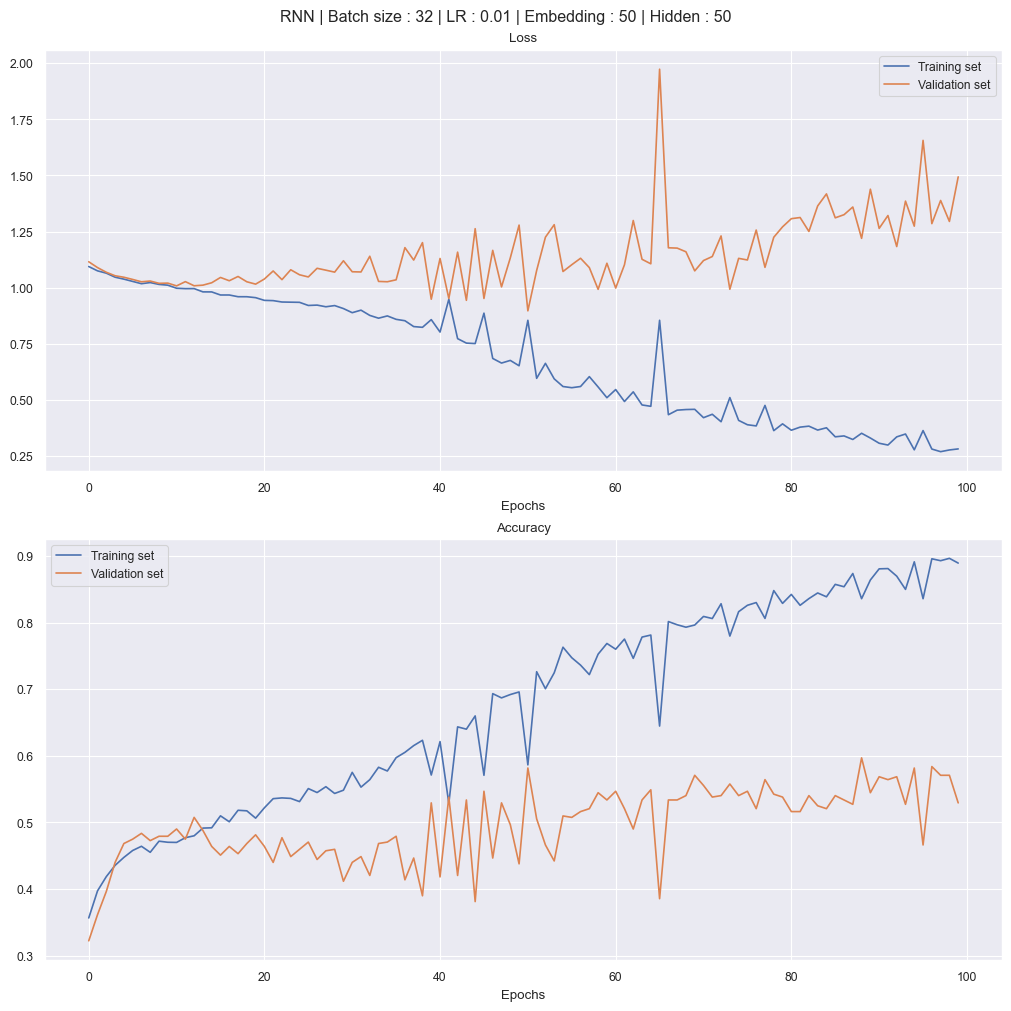

In [46]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM = 50
HIDDEN_DIM = 50
LEARNING_RATE = 1e-2
EPOCHS = 100
BATCH_SIZE = 32

rnn_model = RNN_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM)

train_and_validate_model(rnn_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, verbose=True)

100%|██████████| 150/150 [01:34<00:00,  1.59it/s]


'Test set accuracy: 0.607539'

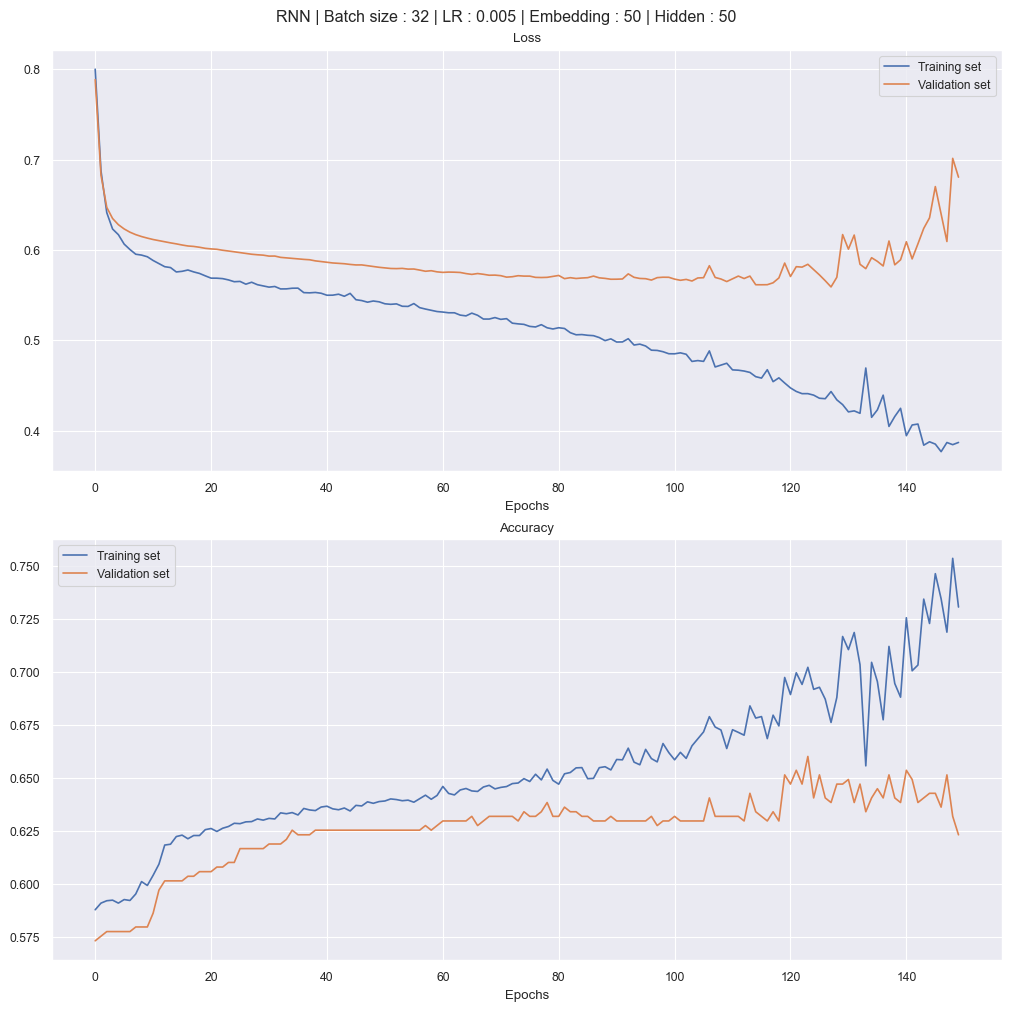

In [135]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM = 50
HIDDEN_DIM = 50
LEARNING_RATE = 5*1e-3
EPOCHS = 150
BATCH_SIZE = 32

rnn_model = RNN_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM)

train_and_validate_model(rnn_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE)

100%|██████████| 150/150 [01:53<00:00,  1.32it/s]


'Test set accuracy: 0.629712'

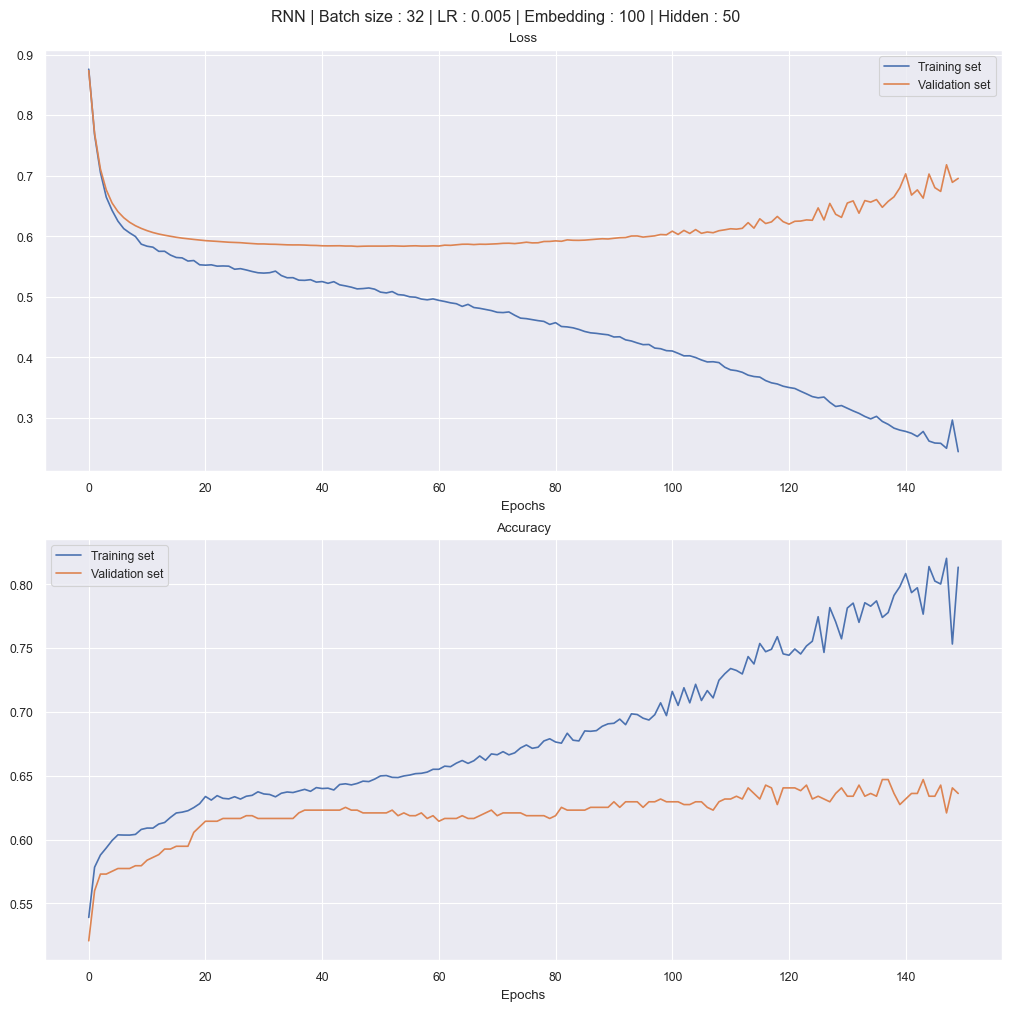

In [136]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM = 100
HIDDEN_DIM = 50
LEARNING_RATE = 5*1e-3
EPOCHS = 150
BATCH_SIZE = 32

rnn_model = RNN_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM)

train_and_validate_model(rnn_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE)

Even with finetuned hyperparameters, the accuracy is low. We are trying a more sophisticated model in the next section.

## LSTM Neural Network

In [48]:
class LSTM_module(nn.Module):

    def __init__(self, vocab_dim, embedding_dim, hidden_dim, nb_lstm_layers, dropout):
        super().__init__()
        # hyperparameters
        self.vocab_dim = vocab_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.nb_lstm_layers = nb_lstm_layers
        self.dropout = dropout

        # embedding layer
        self.embedding_layer = nn.Embedding(
            self.vocab_dim, 
            self.embedding_dim, 
            padding_idx=0
            )

        # RNN layer
        self.lstm_layer=nn.LSTM(
            input_size=self.embedding_dim, 
            hidden_size=self.hidden_dim,
            num_layers=self.nb_lstm_layers,
            batch_first=True,
            dropout=self.dropout
        )
        self.dropout = nn.Dropout(self.dropout)

        # fully connected layer
        self.fc_layer = nn.Linear(self.hidden_dim, 3)

    def forward(self, txt):

        emb_txt = self.embedding_layer(txt)
        lstm_out, _ = self.lstm_layer(emb_txt)
        fc_out = self.fc_layer(lstm_out[:,-1,:])
        
        return fc_out

In [43]:
from skorch import NeuralNetClassifier

lstm_net = NeuralNetClassifier(
    LSTM_module,
    criterion = nn.CrossEntropyLoss(),
    optimizer = torch.optim.SGD,
    device = 'cuda',
    lr = 1e-1,
    batch_size = 16,
    max_epochs = 50,
    module__vocab_dim = len(vocab) + 2,
    module__embedding_dim = 50,
    module__hidden_dim = 50,
    module__nb_lstm_layers = 2,
    module__dropout = 0.3,
)

In [46]:
param_grid = {
    'module__embedding_dim' : [25, 40, 50, 100],
    'module__hidden_dim' : [25],
    'module__dropout' : [0.1, 0.3, 0.5],
    'module__nb_lstm_layers' : [2],
    'batch_size' : [16],
    'max_epochs' : [50],
    'lr' : [1e-1],
}

grid = GridSearchCV(
    estimator=lstm_net, 
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    verbose=10
)

cv_res_lstm = grid.fit(train_txt, train_labels.squeeze())
# print("Best: %f using %s" % (cv_res_lstm.best_score_, cv_res_lstm.best_params_))
# print(cv_res_lstm.best_estimator_)
pd.DataFrame(cv_res_lstm.cv_results_).to_csv('cv_res_lstm_embed.csv', index = False)
# cv_res_df = pd.read_csv('cv_res.csv')


KeyboardInterrupt: 

In [47]:
param_grid = {
    'module__embedding_dim' : [25, 40, 50, 100],
    'module__hidden_dim' : [50],
    'module__dropout' : [0.1, 0.3, 0.5],
    'module__nb_lstm_layers' : [2],
    'batch_size' : [16],
    'max_epochs' : [50],
    'lr' : [1e-1],
}

grid = GridSearchCV(
    estimator=lstm_net, 
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    verbose=10
)

cv_res_lstm = grid.fit(train_txt, train_labels.squeeze())
# print("Best: %f using %s" % (cv_res_lstm.best_score_, cv_res_lstm.best_params_))
# print(cv_res_lstm.best_estimator_)
pd.DataFrame(cv_res_lstm.cv_results_).to_csv('cv_res_lstm_2.csv', index = False)
# cv_res_df = pd.read_csv('cv_res.csv')


In [ ]:
param_grid = {
    'module__embedding_dim' : [25, 40, 50, 100],
    'module__hidden_dim' : [100],
    'module__dropout' : [0.1, 0.3, 0.5],
    'module__nb_lstm_layers' : [2],
    'batch_size' : [16],
    'max_epochs' : [50],
    'lr' : [1e-1],
}

grid = GridSearchCV(
    estimator=lstm_net, 
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    verbose=10
)

cv_res_lstm = grid.fit(train_txt, train_labels.squeeze())
# print("Best: %f using %s" % (cv_res_lstm.best_score_, cv_res_lstm.best_params_))
# print(cv_res_lstm.best_estimator_)
pd.DataFrame(cv_res_lstm.cv_results_).to_csv('cv_res_lstm_3.csv', index = False)
# cv_res_df = pd.read_csv('cv_res.csv')


In [ ]:
param_grid = {
    'module__embedding_dim' : [25, 40, 50, 100],
    'module__hidden_dim' : [25],
    'module__dropout' : [0.1, 0.3, 0.5],
    'module__nb_lstm_layers' : [2],
    'batch_size' : [32],
    'max_epochs' : [50],
    'lr' : [1e-1],
}

grid = GridSearchCV(
    estimator=lstm_net, 
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    verbose=10
)

cv_res_lstm = grid.fit(train_txt, train_labels.squeeze())
# print("Best: %f using %s" % (cv_res_lstm.best_score_, cv_res_lstm.best_params_))
# print(cv_res_lstm.best_estimator_)
pd.DataFrame(cv_res_lstm.cv_results_).to_csv('cv_res_lstm_11.csv', index = False)
# cv_res_df = pd.read_csv('cv_res.csv')


In [ ]:
param_grid = {
    'module__embedding_dim' : [25, 40, 50, 100],
    'module__hidden_dim' : [25],
    'module__dropout' : [0.1, 0.3, 0.5],
    'module__nb_lstm_layers' : [2],
    'batch_size' : [16],
    'max_epochs' : [100],
    'lr' : [1e-1],
}

grid = GridSearchCV(
    estimator=lstm_net, 
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    verbose=10
)

cv_res_lstm = grid.fit(train_txt, train_labels.squeeze())
# print("Best: %f using %s" % (cv_res_lstm.best_score_, cv_res_lstm.best_params_))
# print(cv_res_lstm.best_estimator_)
pd.DataFrame(cv_res_lstm.cv_results_).to_csv('cv_res_lstm_111.csv', index = False)
# cv_res_df = pd.read_csv('cv_res.csv')


In [ ]:
param_grid = {
    'module__embedding_dim' : [25, 40, 50, 100],
    'module__hidden_dim' : [50],
    'module__dropout' : [0.1, 0.3, 0.5],
    'module__nb_lstm_layers' : [2],
    'batch_size' : [32],
    'max_epochs' : [50],
    'lr' : [1e-1],
}

grid = GridSearchCV(
    estimator=lstm_net, 
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    verbose=10
)

cv_res_lstm = grid.fit(train_txt, train_labels.squeeze())
# print("Best: %f using %s" % (cv_res_lstm.best_score_, cv_res_lstm.best_params_))
# print(cv_res_lstm.best_estimator_)
pd.DataFrame(cv_res_lstm.cv_results_).to_csv('cv_res_lstm_22.csv', index = False)
# cv_res_df = pd.read_csv('cv_res.csv')


In [ ]:
param_grid = {
    'module__embedding_dim' : [25, 40, 50, 100],
    'module__hidden_dim' : [50],
    'module__dropout' : [0.1, 0.3, 0.5],
    'module__nb_lstm_layers' : [2],
    'batch_size' : [16],
    'max_epochs' : [100],
    'lr' : [1e-1],
}

grid = GridSearchCV(
    estimator=lstm_net, 
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    verbose=10
)

cv_res_lstm = grid.fit(train_txt, train_labels.squeeze())
# print("Best: %f using %s" % (cv_res_lstm.best_score_, cv_res_lstm.best_params_))
# print(cv_res_lstm.best_estimator_)
pd.DataFrame(cv_res_lstm.cv_results_).to_csv('cv_res_lstm_222.csv', index = False)
# cv_res_df = pd.read_csv('cv_res.csv')


In [ ]:
param_grid = {
    'module__embedding_dim' : [25, 40, 50, 100],
    'module__hidden_dim' : [100],
    'module__dropout' : [0.1, 0.3, 0.5],
    'module__nb_lstm_layers' : [2],
    'batch_size' : [32],
    'max_epochs' : [50],
    'lr' : [1e-1],
}

grid = GridSearchCV(
    estimator=lstm_net, 
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    verbose=10
)

cv_res_lstm = grid.fit(train_txt, train_labels.squeeze())
# print("Best: %f using %s" % (cv_res_lstm.best_score_, cv_res_lstm.best_params_))
# print(cv_res_lstm.best_estimator_)
pd.DataFrame(cv_res_lstm.cv_results_).to_csv('cv_res_lstm_33.csv', index = False)
# cv_res_df = pd.read_csv('cv_res.csv')


In [ ]:
param_grid = {
    'module__embedding_dim' : [25, 40, 50, 100],
    'module__hidden_dim' : [100],
    'module__dropout' : [0.1, 0.3, 0.5],
    'module__nb_lstm_layers' : [2],
    'batch_size' : [16],
    'max_epochs' : [100],
    'lr' : [1e-1],
}

grid = GridSearchCV(
    estimator=lstm_net, 
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    verbose=10
)

cv_res_lstm = grid.fit(train_txt, train_labels.squeeze())
# print("Best: %f using %s" % (cv_res_lstm.best_score_, cv_res_lstm.best_params_))
# print(cv_res_lstm.best_estimator_)
pd.DataFrame(cv_res_lstm.cv_results_).to_csv('cv_res_lstm_333.csv', index = False)
# cv_res_df = pd.read_csv('cv_res.csv')


In [45]:
pd.read_csv('cv_res_lstm_1.csv')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_lr,param_max_epochs,param_module__dropout,param_module__embedding_dim,param_module__hidden_dim,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,178.202861,2.483143,0.319866,0.032603,16,0.1,50,0.1,25,25,"{'batch_size': 16, 'lr': 0.1, 'max_epochs': 50...",0.624828,0.616552,0.640000,0.593103,0.535172,0.601931,0.036666,4
1,173.232858,2.397838,0.359913,0.072015,16,0.1,50,0.1,40,25,"{'batch_size': 16, 'lr': 0.1, 'max_epochs': 50...",0.638621,0.602759,0.630345,0.627586,0.583448,0.616552,0.020421,3
2,172.821639,2.666628,0.390127,0.078041,16,0.1,50,0.1,50,25,"{'batch_size': 16, 'lr': 0.1, 'max_epochs': 50...",0.655172,0.655172,0.635862,0.657931,0.637241,0.648276,0.009635,2
3,129.145798,50.895962,0.157394,0.056465,16,0.1,50,0.1,100,25,"{'batch_size': 16, 'lr': 0.1, 'max_epochs': 50...",0.644138,0.648276,0.648276,0.678621,0.642759,0.652414,0.013287,1


100%|██████████| 150/150 [06:21<00:00,  2.54s/it]


'Test set accuracy: 0.671840'

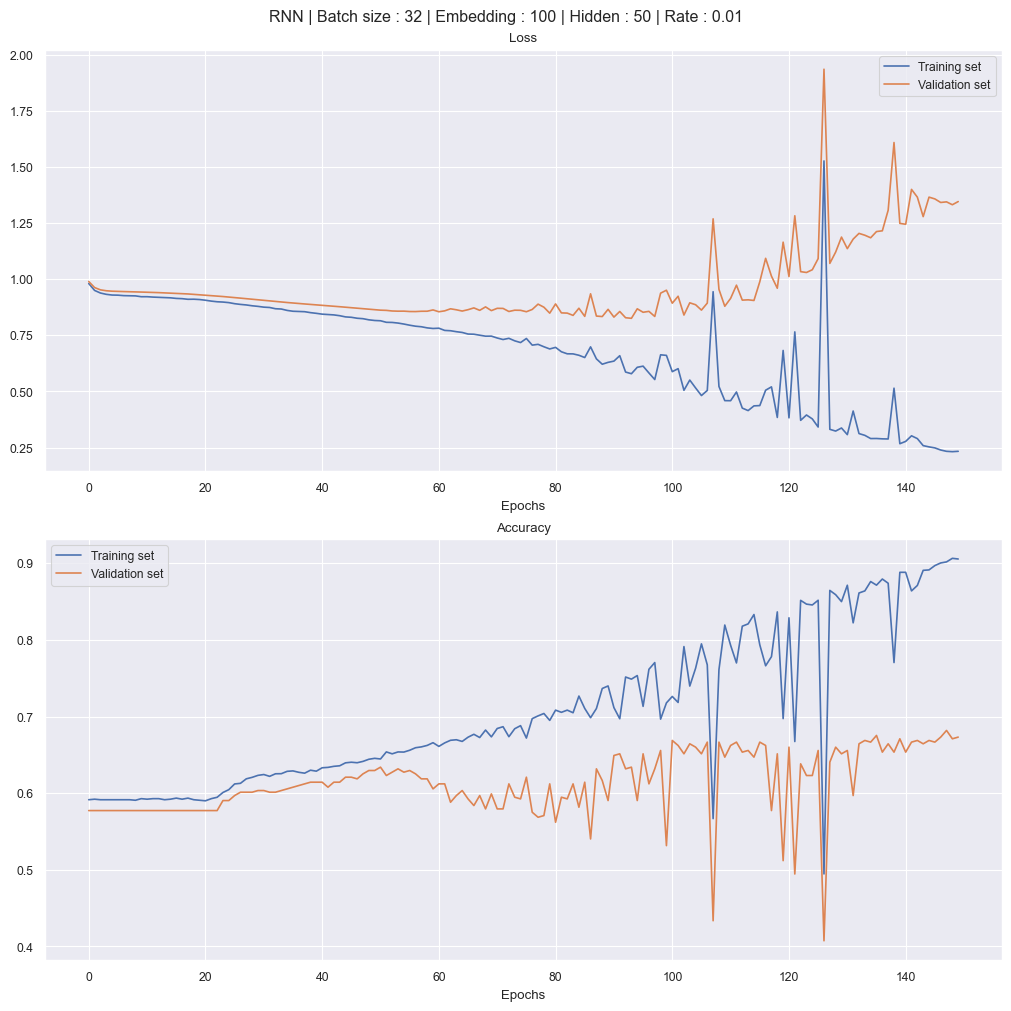

In [65]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =100
HIDDEN_DIM = 50
DROPOUT = 0.3
NB_LAYERS = 2

LEARNING_RATE = 1e-2
EPOCHS = 150
BATCH_SIZE = 32 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE)

100%|██████████| 150/150 [05:00<00:00,  2.00s/it]


'Test set accuracy: 0.694013'

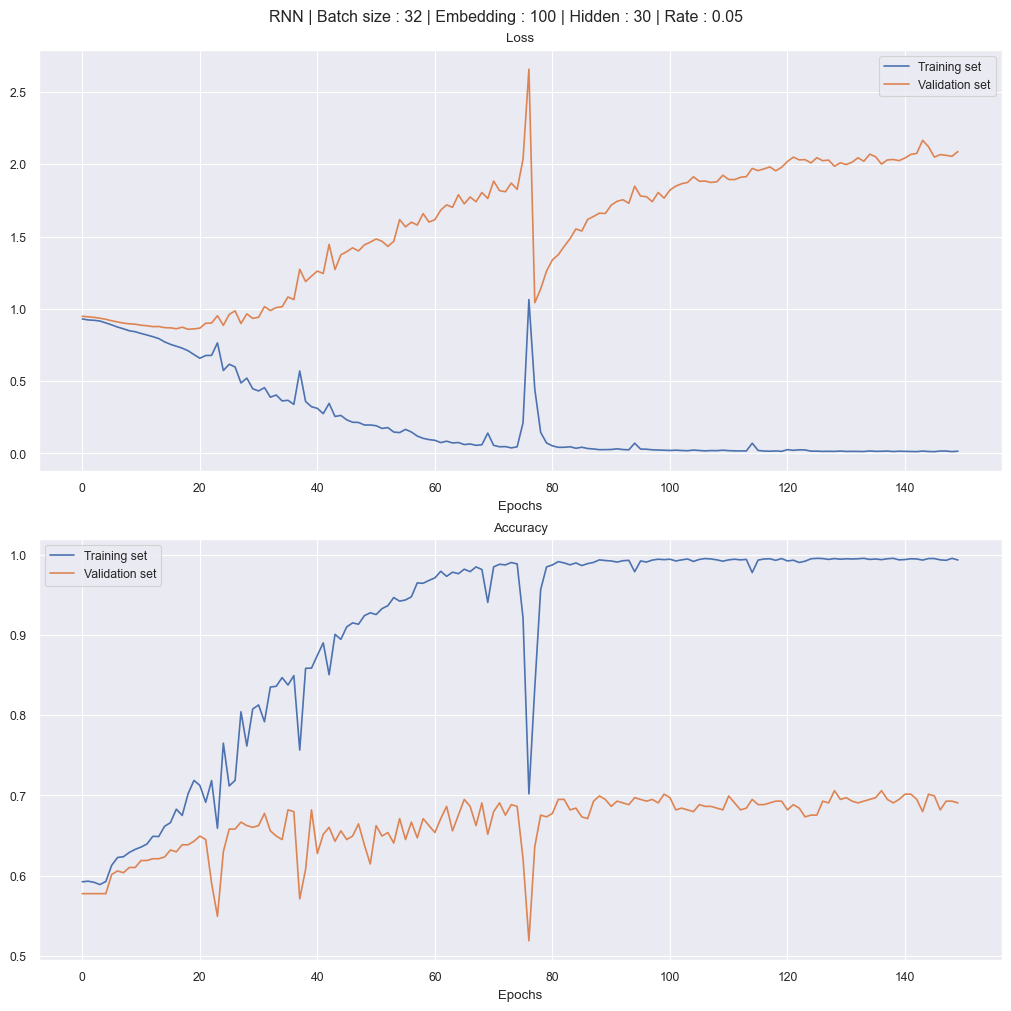

In [67]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =100
HIDDEN_DIM = 30
DROPOUT = 0.3
NB_LAYERS = 2

LEARNING_RATE = 5*1e-2
EPOCHS = 150
BATCH_SIZE = 32 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE)

100%|██████████| 150/150 [05:33<00:00,  2.23s/it]


'Test set accuracy: 0.600887'

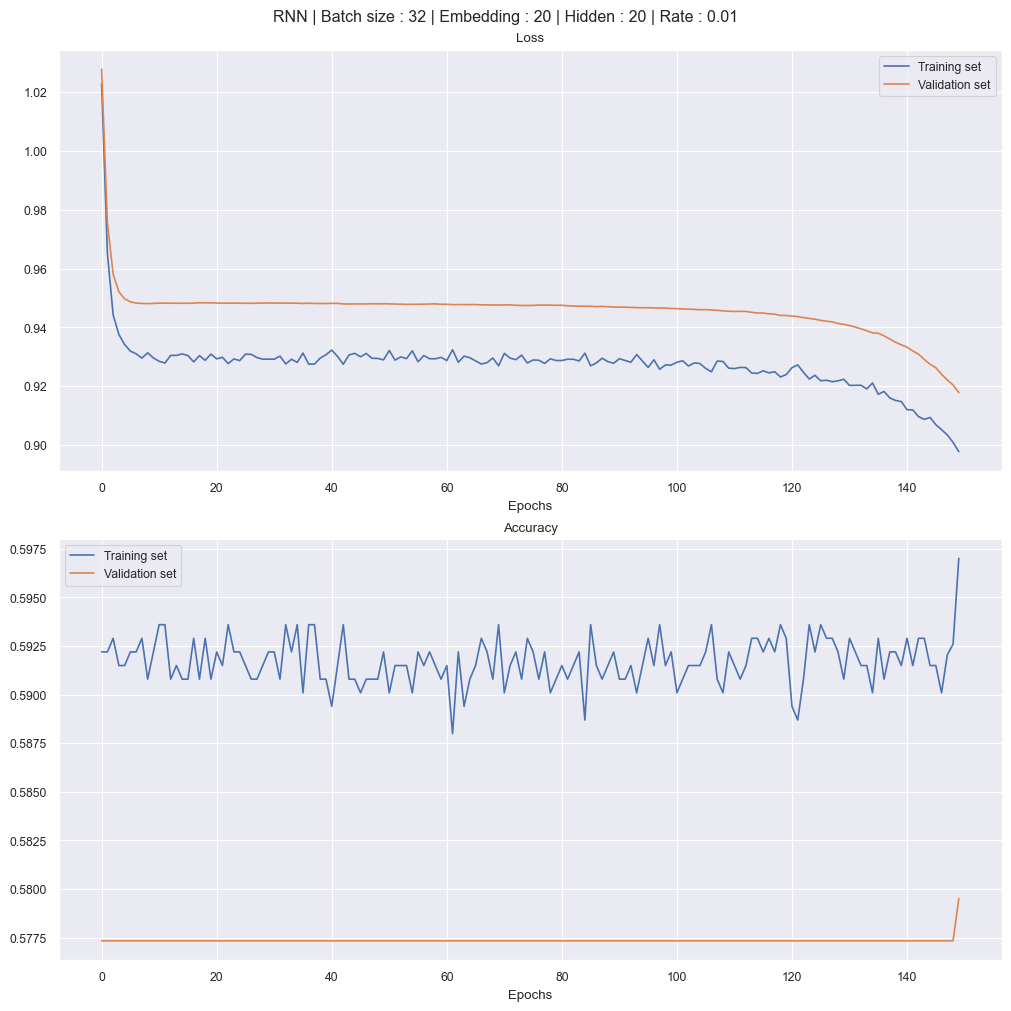

In [69]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM = 20
HIDDEN_DIM = 20
DROPOUT = 0.4
NB_LAYERS = 3

LEARNING_RATE = 1e-2
EPOCHS = 150
BATCH_SIZE = 32 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE)

100%|██████████| 150/150 [05:29<00:00,  2.20s/it]


'Test set accuracy: 0.702882'

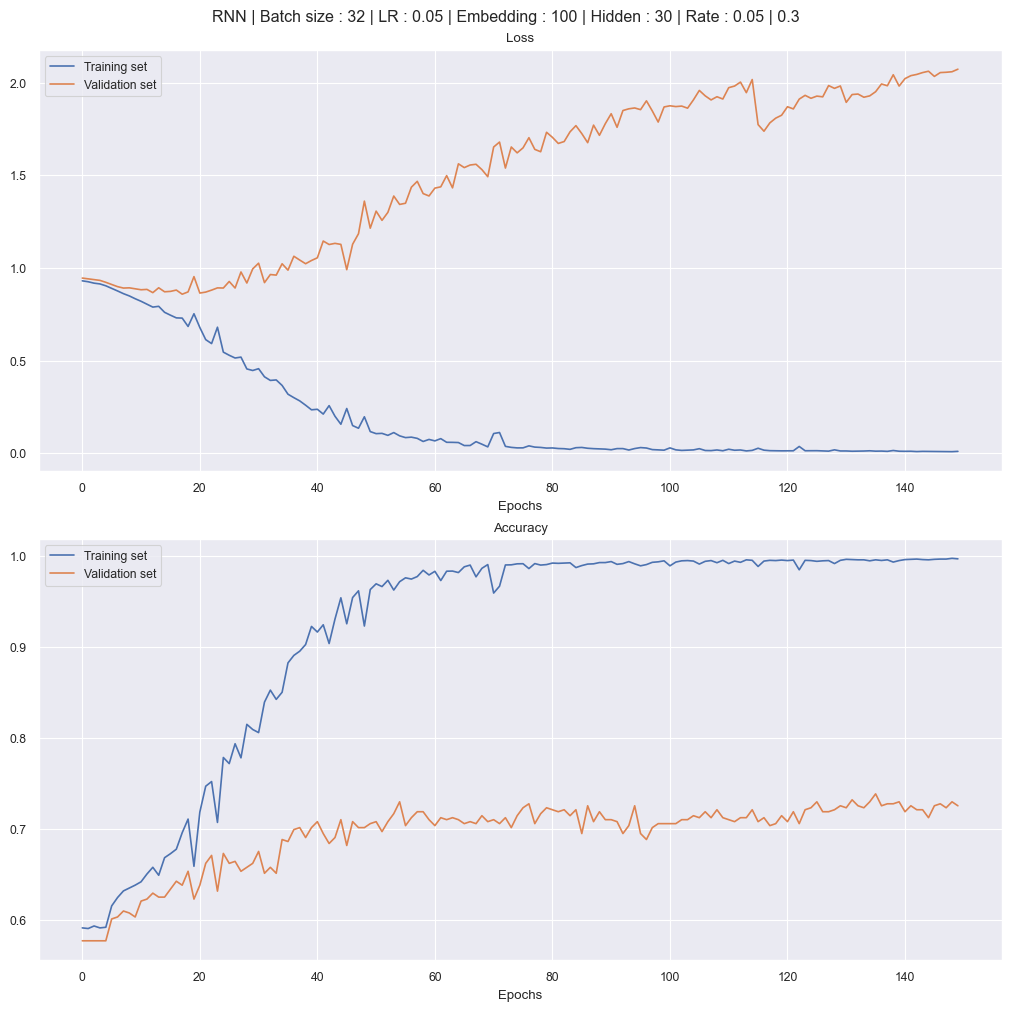

In [79]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =100
HIDDEN_DIM = 30
DROPOUT = 0.3
NB_LAYERS = 2

LEARNING_RATE = 5*1e-2
EPOCHS = 150
BATCH_SIZE = 32 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, DROPOUT=DROPOUT)

100%|██████████| 150/150 [09:47<00:00,  3.92s/it]


'Test set accuracy: 0.689579'

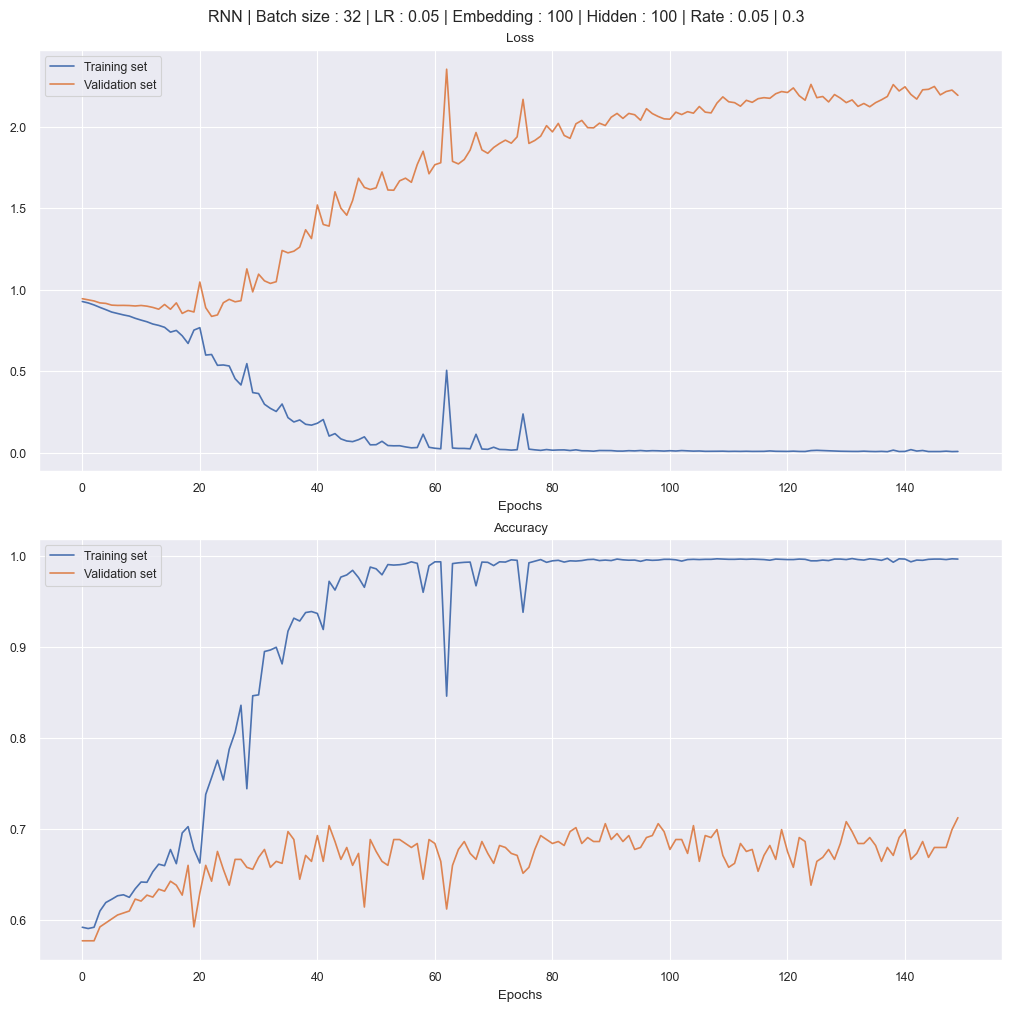

In [81]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =100
HIDDEN_DIM = 100
DROPOUT = 0.3
NB_LAYERS = 2

LEARNING_RATE = 5*1e-2
EPOCHS = 150
BATCH_SIZE = 32 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, DROPOUT=DROPOUT)

100%|██████████| 150/150 [07:48<00:00,  3.12s/it]


'Test set accuracy: 0.694013'

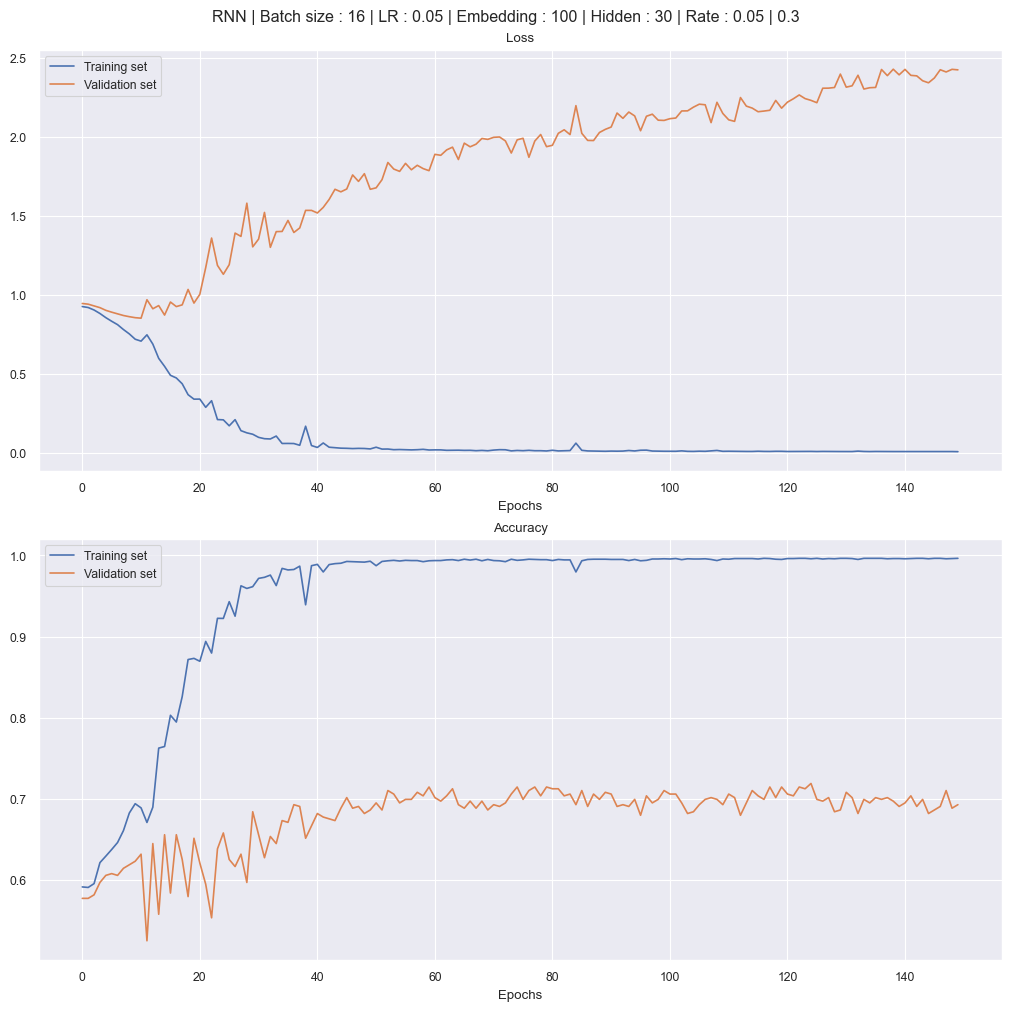

In [87]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =100
HIDDEN_DIM = 30
DROPOUT = 0.3
NB_LAYERS = 2

LEARNING_RATE = 5*1e-2
EPOCHS = 150
BATCH_SIZE = 16 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, DROPOUT=DROPOUT)

100%|██████████| 150/150 [12:32<00:00,  5.02s/it]


'Test set accuracy: 0.709534'

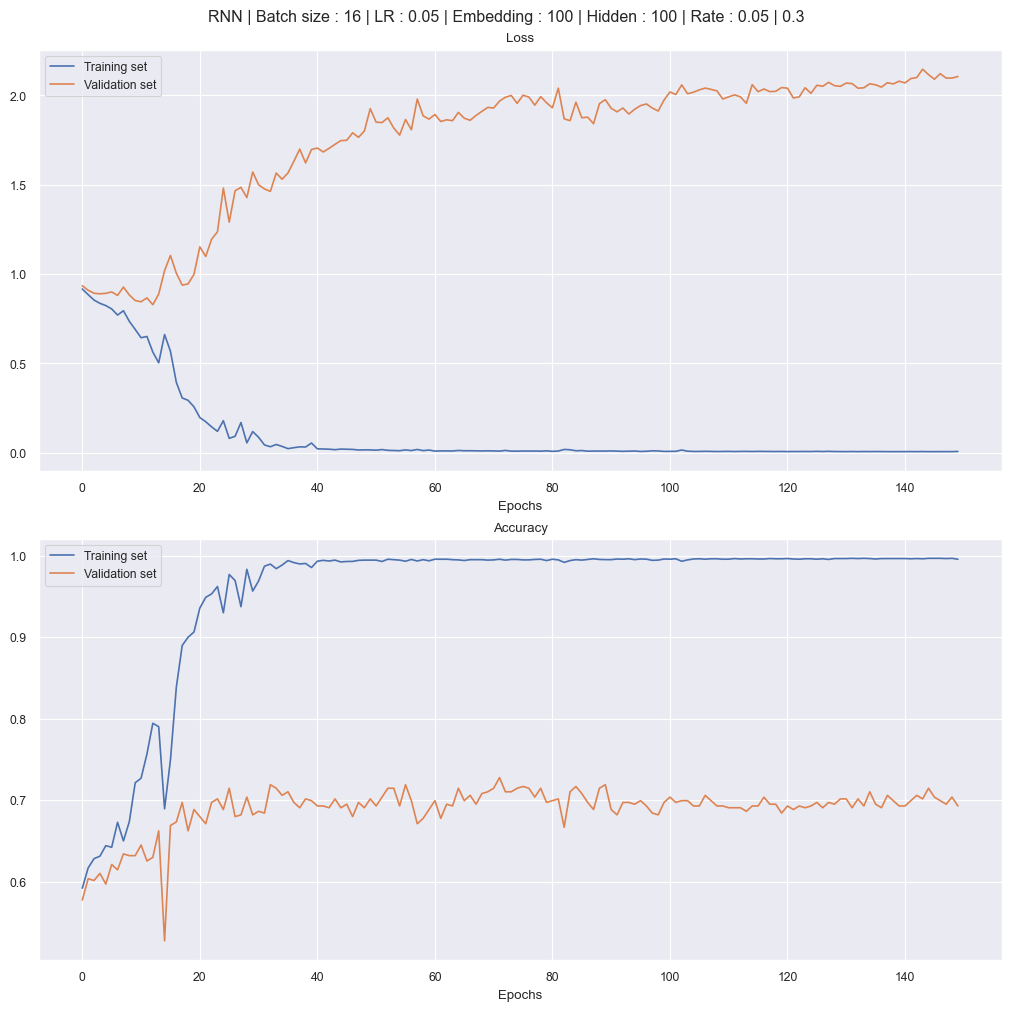

In [90]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =100
HIDDEN_DIM = 100
DROPOUT = 0.3
NB_LAYERS = 2

LEARNING_RATE = 5*1e-2
EPOCHS = 150
BATCH_SIZE = 16 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, DROPOUT=DROPOUT)

100%|██████████| 150/150 [05:13<00:00,  2.09s/it]


'Test set accuracy: 0.702882'

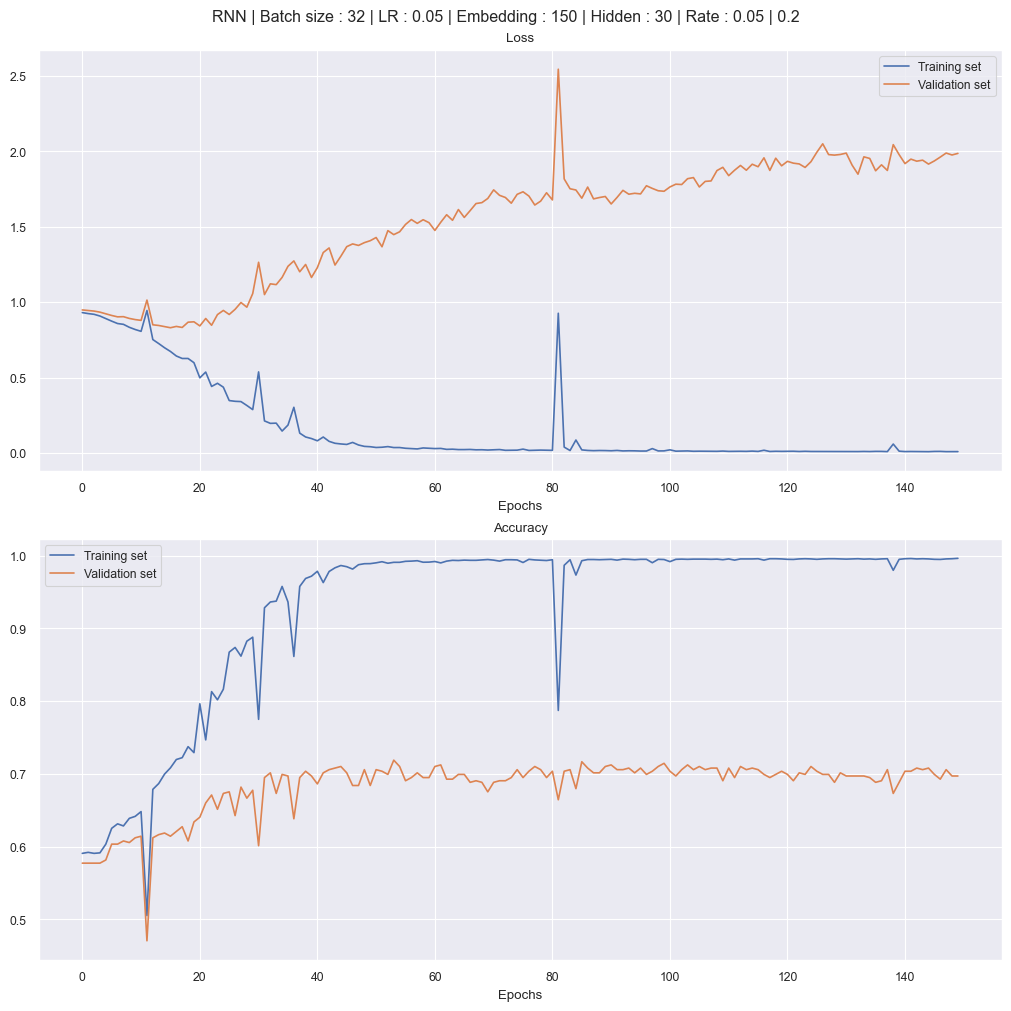

In [99]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =150
HIDDEN_DIM = 30
DROPOUT = 0.2
NB_LAYERS = 2

LEARNING_RATE = 5*1e-2
EPOCHS = 150
BATCH_SIZE = 32 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, DROPOUT=DROPOUT)

100%|██████████| 150/150 [05:29<00:00,  2.20s/it]


'Test set accuracy: 0.709534'

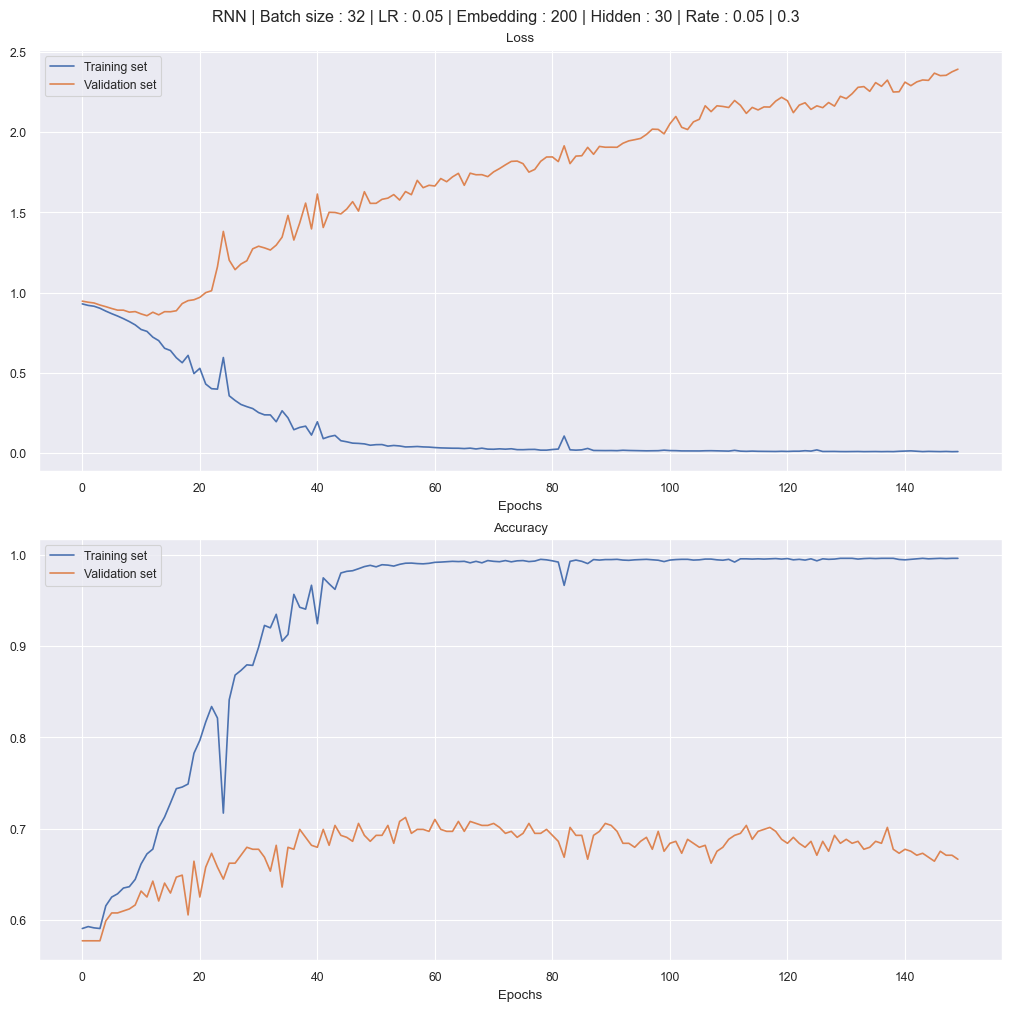

In [100]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =200
HIDDEN_DIM = 30
DROPOUT = 0.3
NB_LAYERS = 2

LEARNING_RATE = 5*1e-2
EPOCHS = 150
BATCH_SIZE = 32 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, DROPOUT=DROPOUT)

100%|██████████| 150/150 [05:30<00:00,  2.20s/it]


'Test set accuracy: 0.685144'

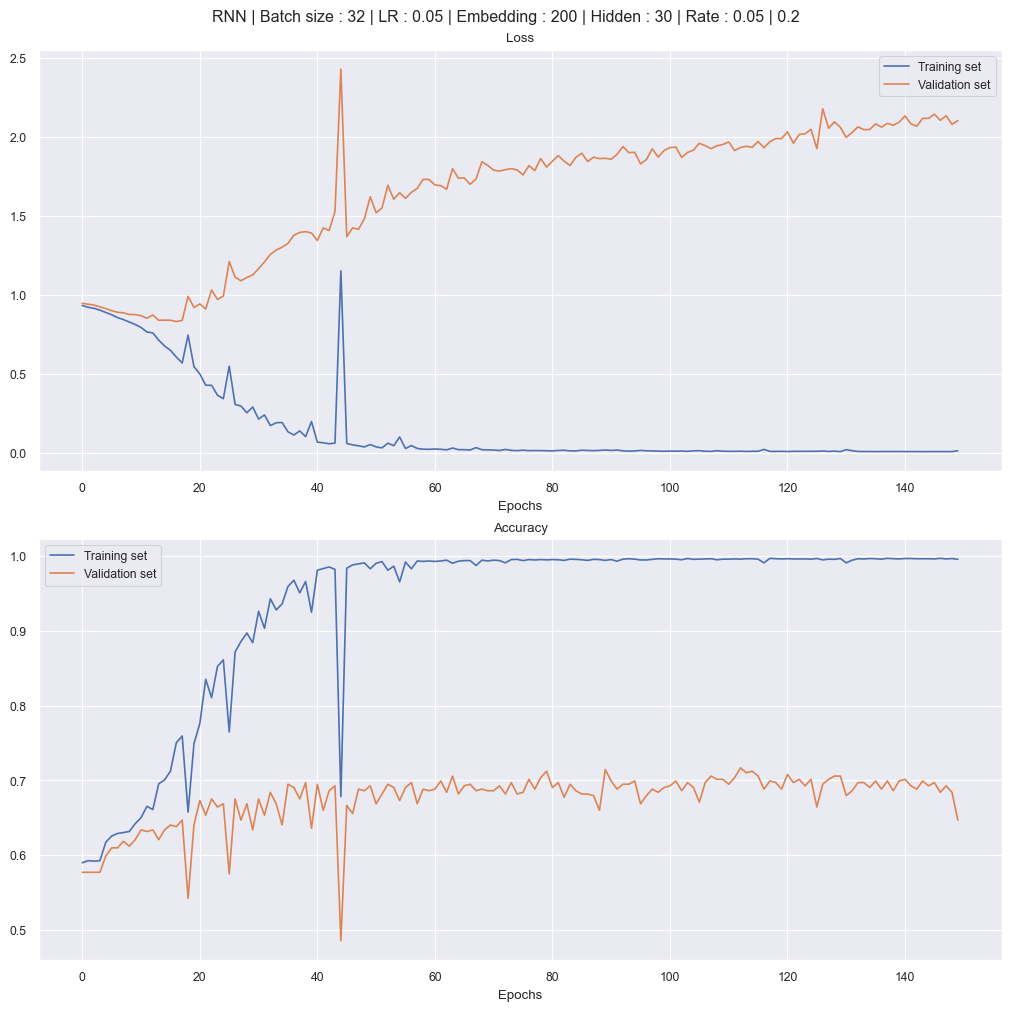

In [101]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =200
HIDDEN_DIM = 30
DROPOUT = 0.2
NB_LAYERS = 2

LEARNING_RATE = 5*1e-2
EPOCHS = 150
BATCH_SIZE = 32 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, DROPOUT=DROPOUT)

100%|██████████| 150/150 [07:29<00:00,  3.00s/it]


'Test set accuracy: 0.698448'

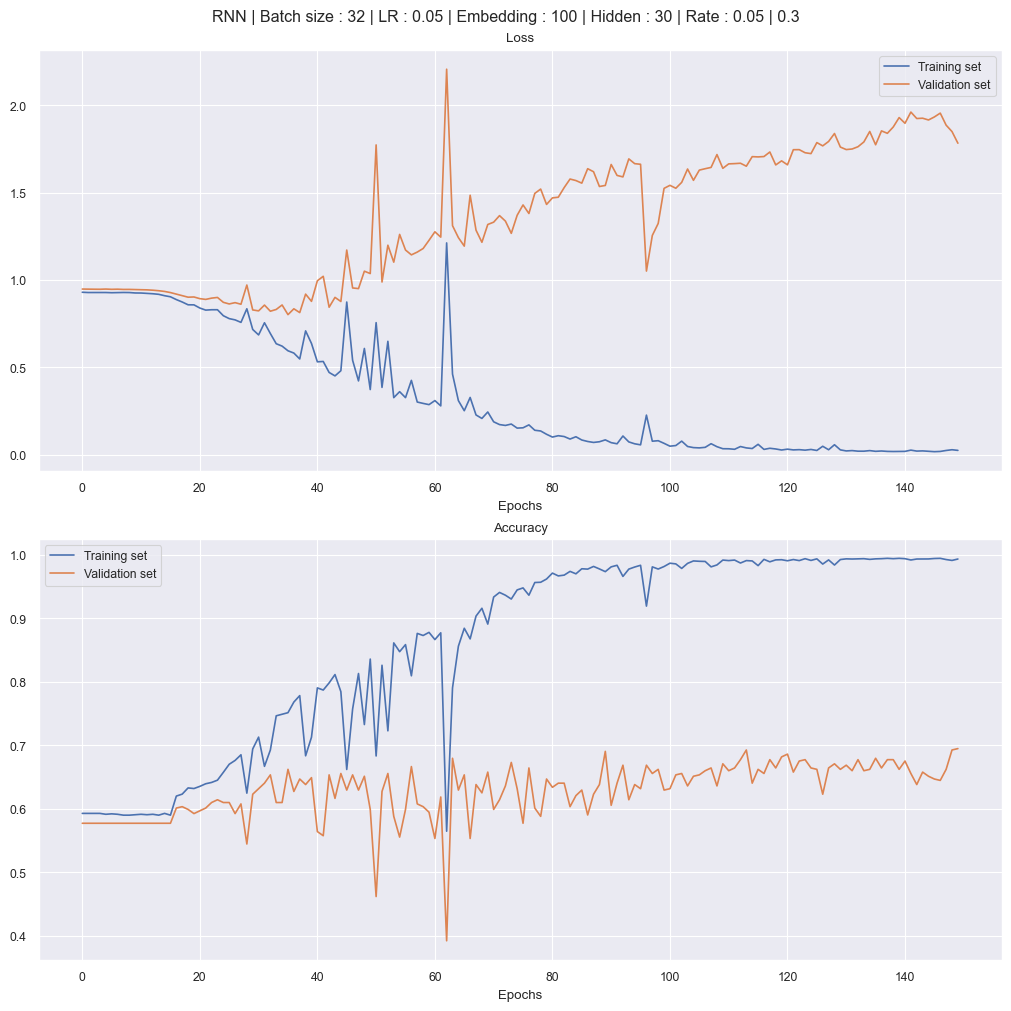

In [104]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =100
HIDDEN_DIM = 30
DROPOUT = 0.3
NB_LAYERS = 3

LEARNING_RATE = 5*1e-2
EPOCHS = 150
BATCH_SIZE = 32 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, DROPOUT=DROPOUT)

100%|██████████| 150/150 [07:44<00:00,  3.10s/it]


'Test set accuracy: 0.674058'

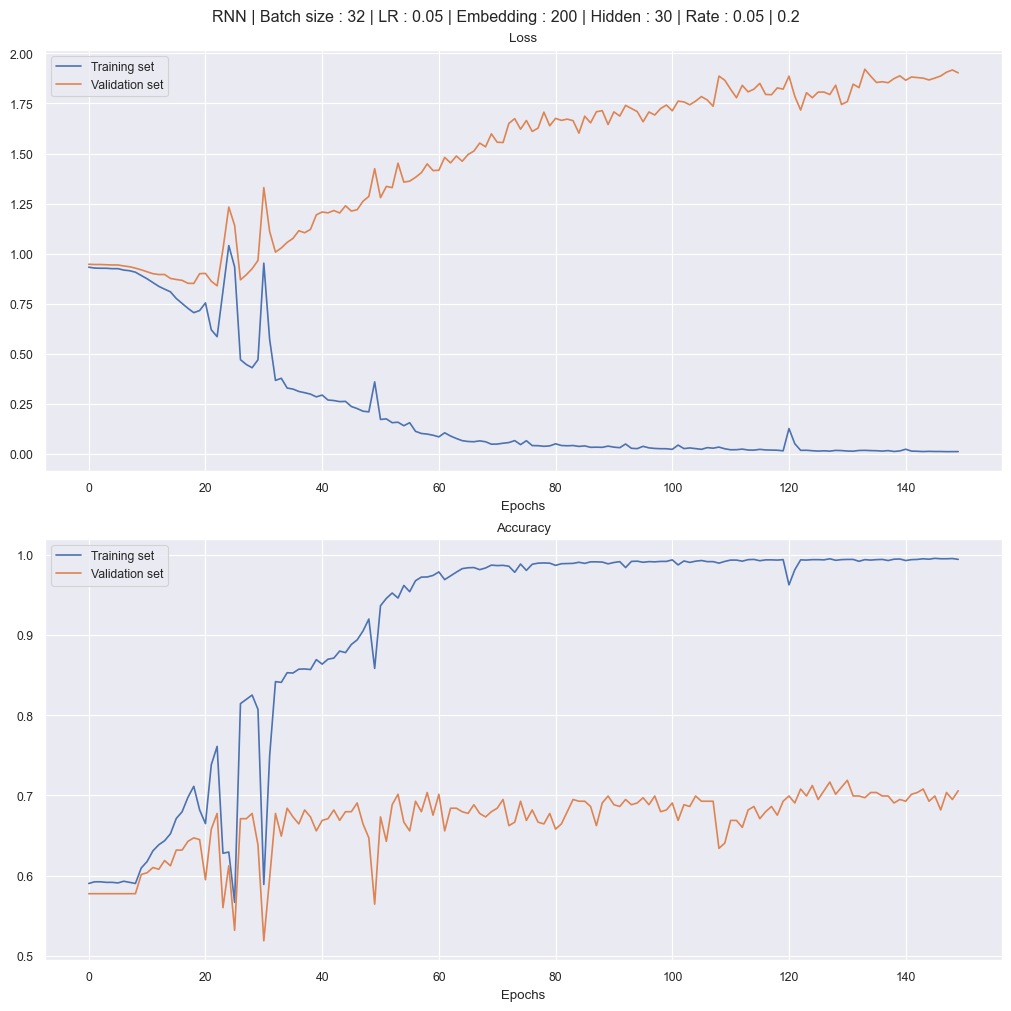

In [106]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =200
HIDDEN_DIM = 30
DROPOUT = 0.2
NB_LAYERS = 3

LEARNING_RATE = 5*1e-2
EPOCHS = 150
BATCH_SIZE = 32 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, DROPOUT=DROPOUT)

100%|██████████| 200/200 [07:05<00:00,  2.13s/it]


'Test set accuracy: 0.731707'

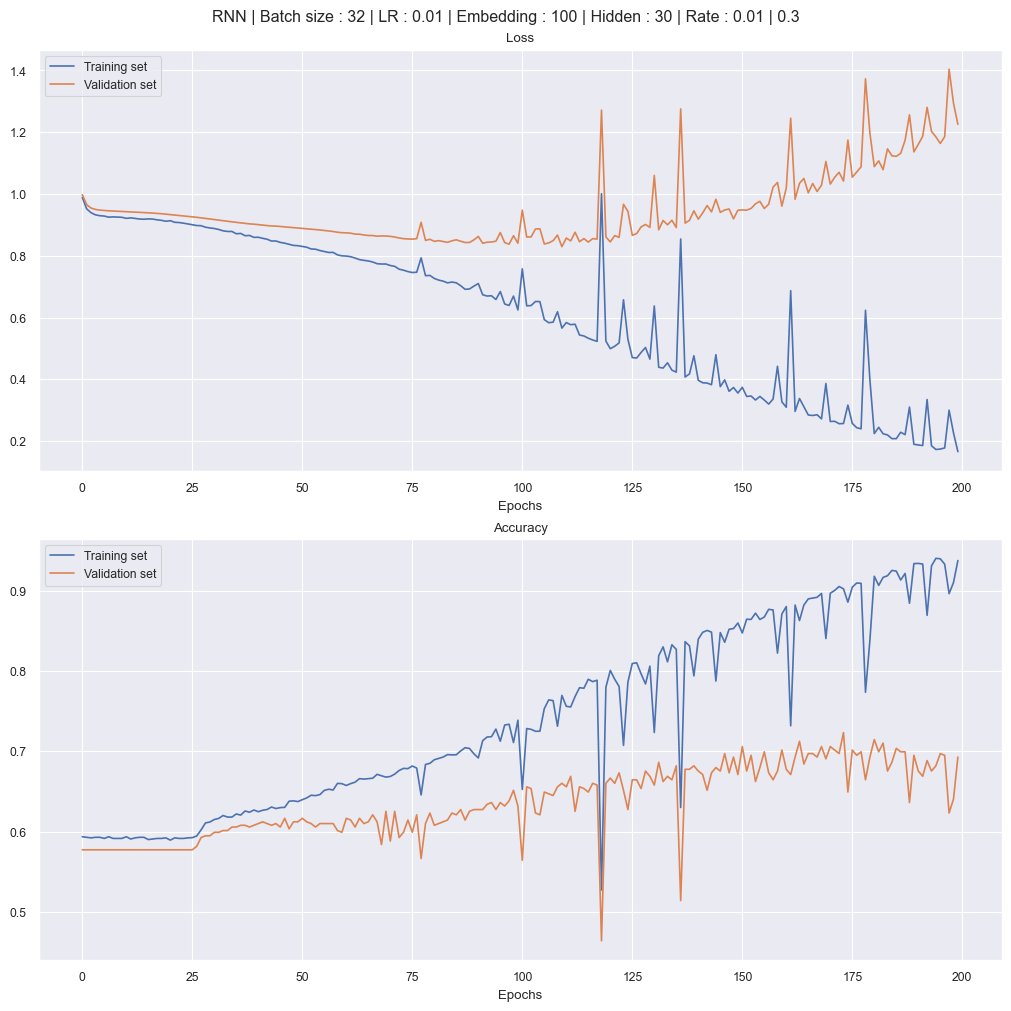

In [107]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =100
HIDDEN_DIM = 30
DROPOUT = 0.3
NB_LAYERS = 2

LEARNING_RATE = 1e-2
EPOCHS = 200
BATCH_SIZE = 32 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, DROPOUT=DROPOUT)

100%|██████████| 150/150 [05:43<00:00,  2.29s/it]


'Test set accuracy: 0.680710'

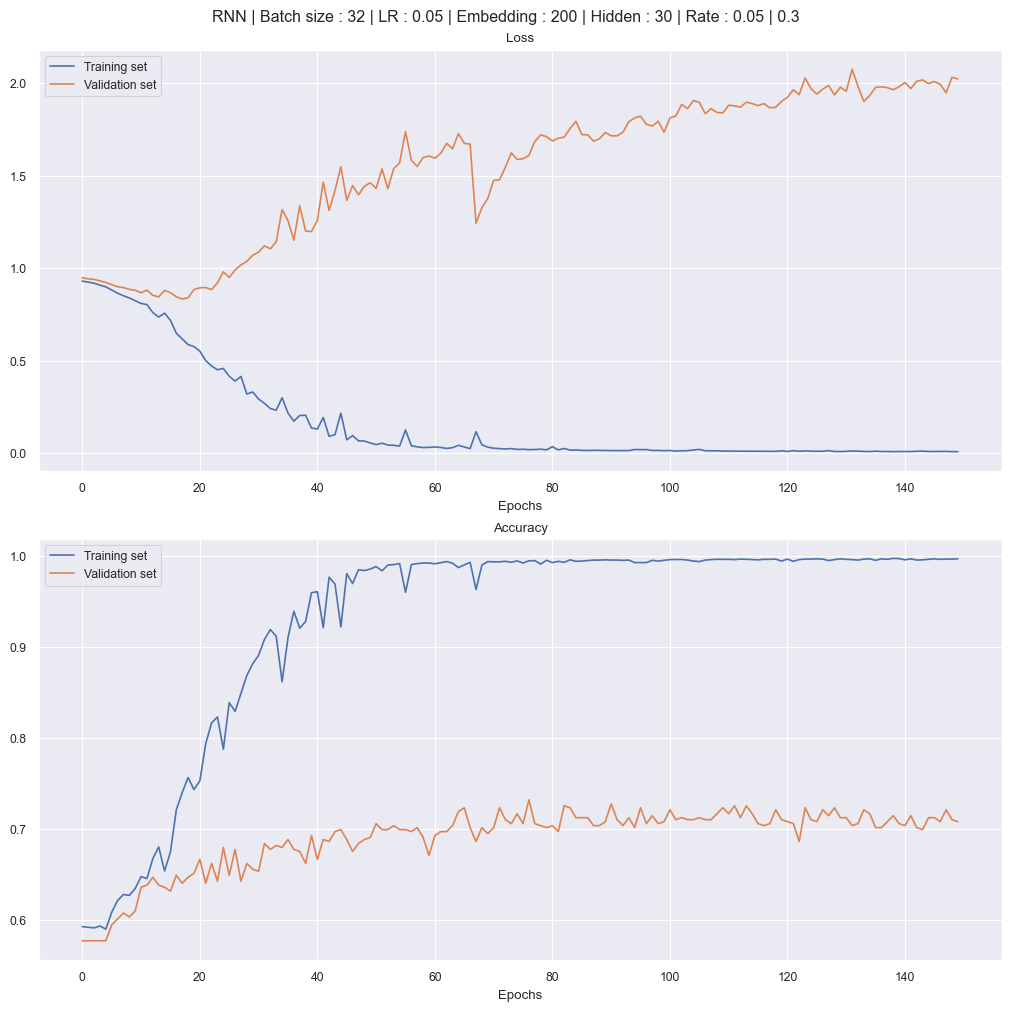

In [108]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =200
HIDDEN_DIM = 30
DROPOUT = 0.3
NB_LAYERS = 2

LEARNING_RATE = 5*1e-2
EPOCHS = 150
BATCH_SIZE = 32 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, DROPOUT=DROPOUT)

100%|██████████| 150/150 [07:42<00:00,  3.08s/it]


'Test set accuracy: 0.685144'

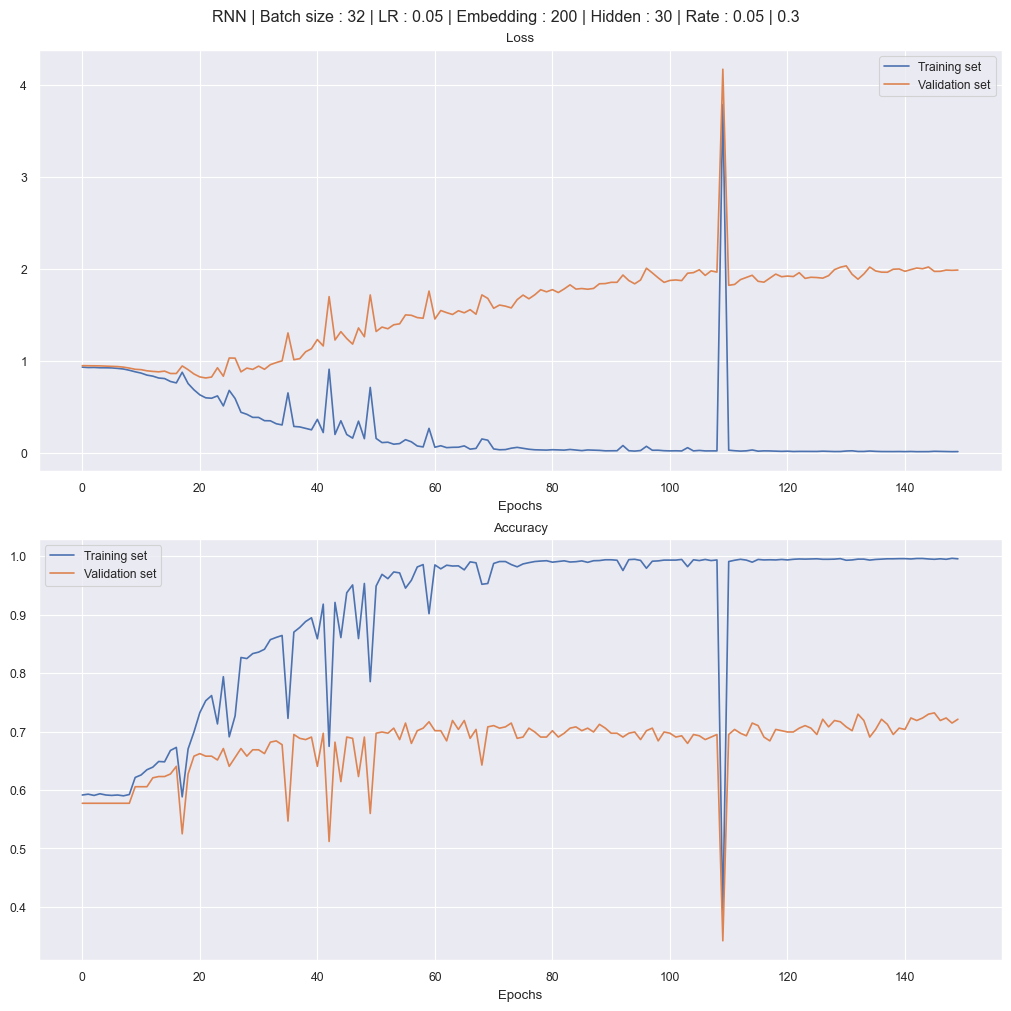

In [109]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =200
HIDDEN_DIM = 30
DROPOUT = 0.3
NB_LAYERS = 3

LEARNING_RATE = 5*1e-2
EPOCHS = 150
BATCH_SIZE = 32 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, DROPOUT=DROPOUT)

100%|██████████| 150/150 [07:46<00:00,  3.11s/it]


'Test set accuracy: 0.687361'

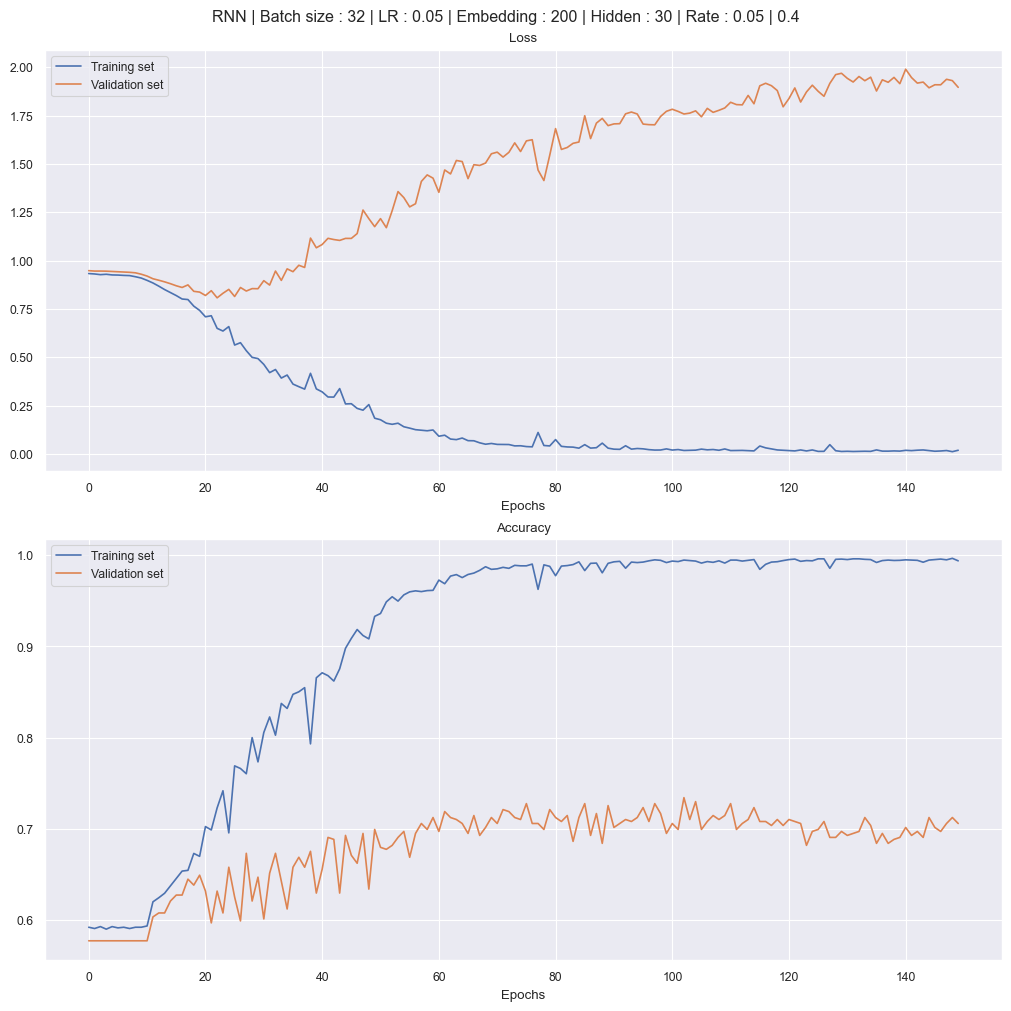

In [110]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =200
HIDDEN_DIM = 30
DROPOUT = 0.4
NB_LAYERS = 3

LEARNING_RATE = 5*1e-2
EPOCHS = 150
BATCH_SIZE = 32 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, DROPOUT=DROPOUT)

100%|██████████| 150/150 [05:46<00:00,  2.31s/it]


'Test set accuracy: 0.676275'

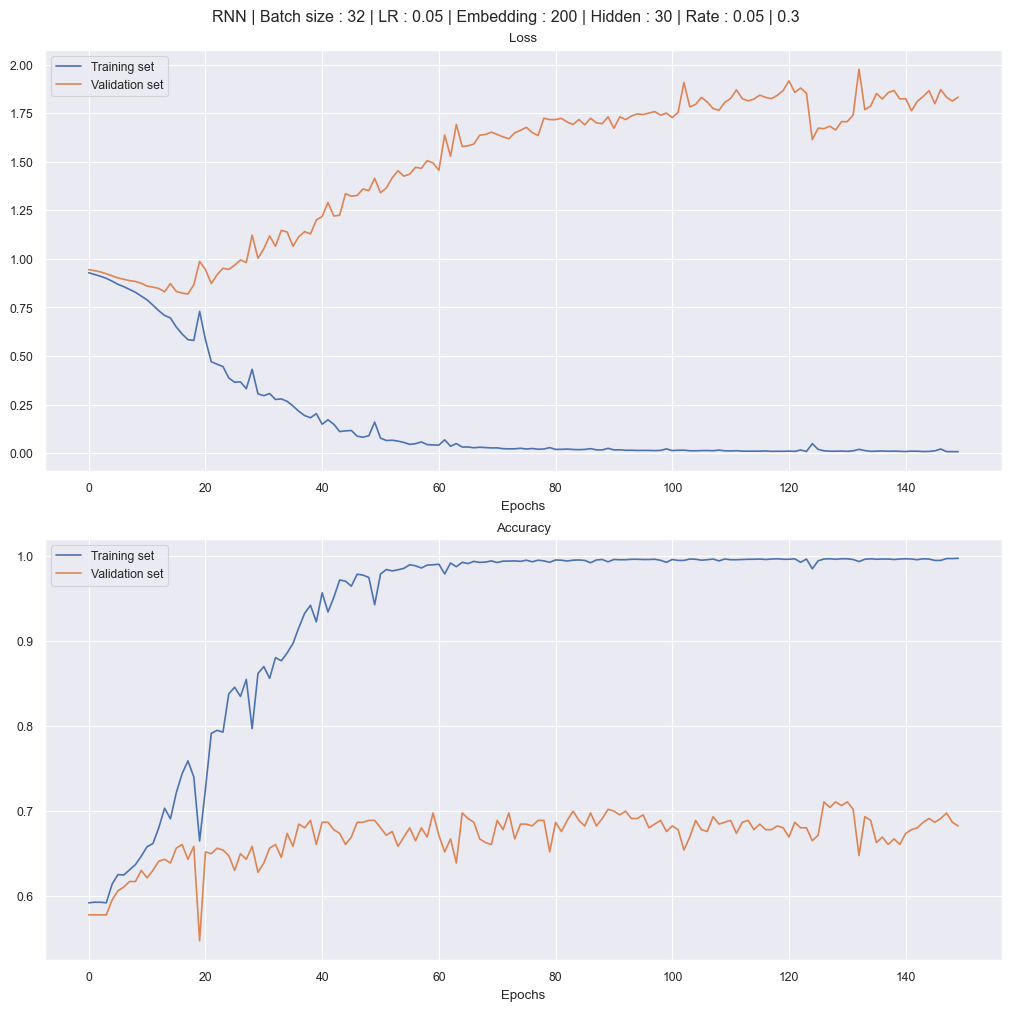

In [112]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =200
HIDDEN_DIM = 30
DROPOUT = 0.3
NB_LAYERS = 2

LEARNING_RATE = 5*1e-2
EPOCHS = 150
BATCH_SIZE = 32 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, DROPOUT=DROPOUT)

100%|██████████| 250/250 [08:51<00:00,  2.13s/it]


'Test set accuracy: 0.607539'

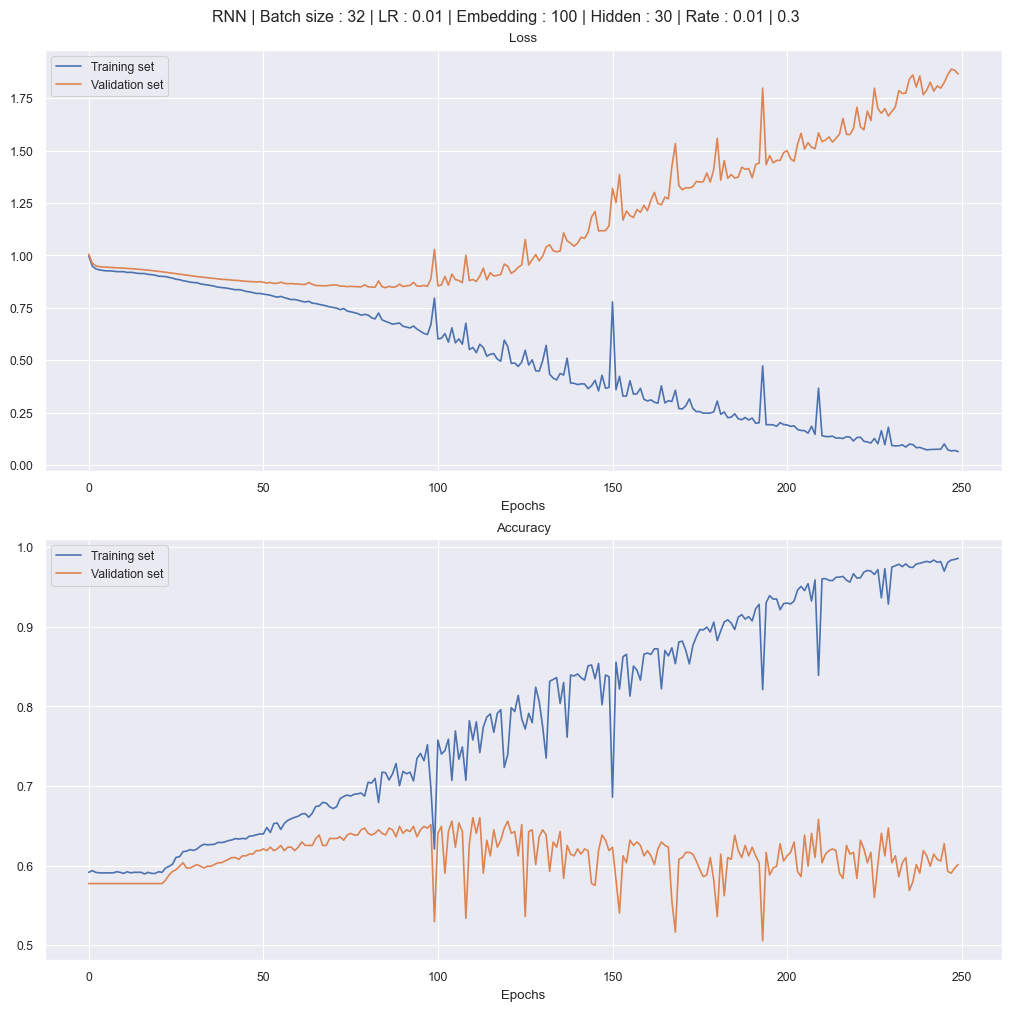

In [113]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =100
HIDDEN_DIM = 30
DROPOUT = 0.3
NB_LAYERS = 2

LEARNING_RATE = 1e-2
EPOCHS = 250
BATCH_SIZE = 32 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, DROPOUT=DROPOUT)

100%|██████████| 250/250 [09:13<00:00,  2.21s/it]


'Test set accuracy: 0.638581'

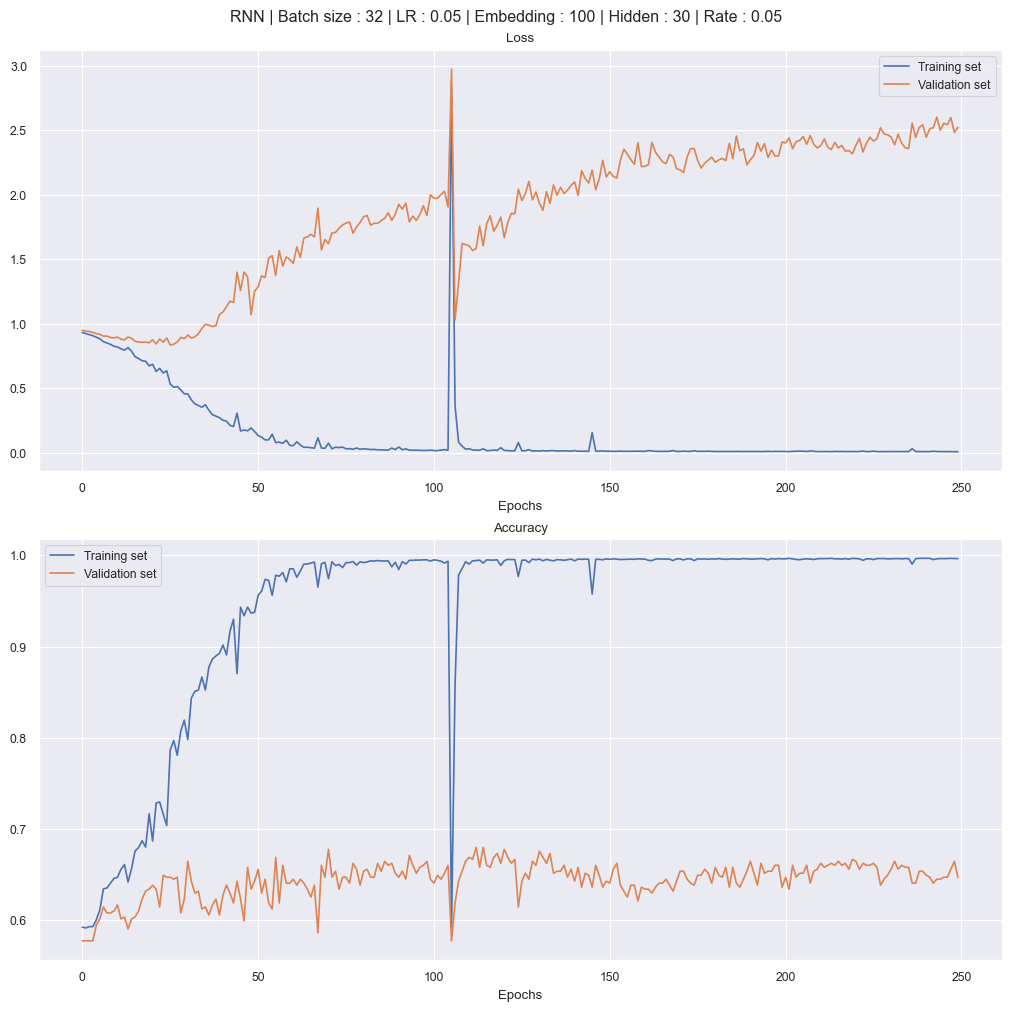

In [114]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =100
HIDDEN_DIM = 30
DROPOUT = 0.3
NB_LAYERS = 2

LEARNING_RATE = 5*1e-2
EPOCHS = 250
BATCH_SIZE = 32 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE)

100%|██████████| 250/250 [12:00<00:00,  2.88s/it]


'Test set accuracy: 0.649667'

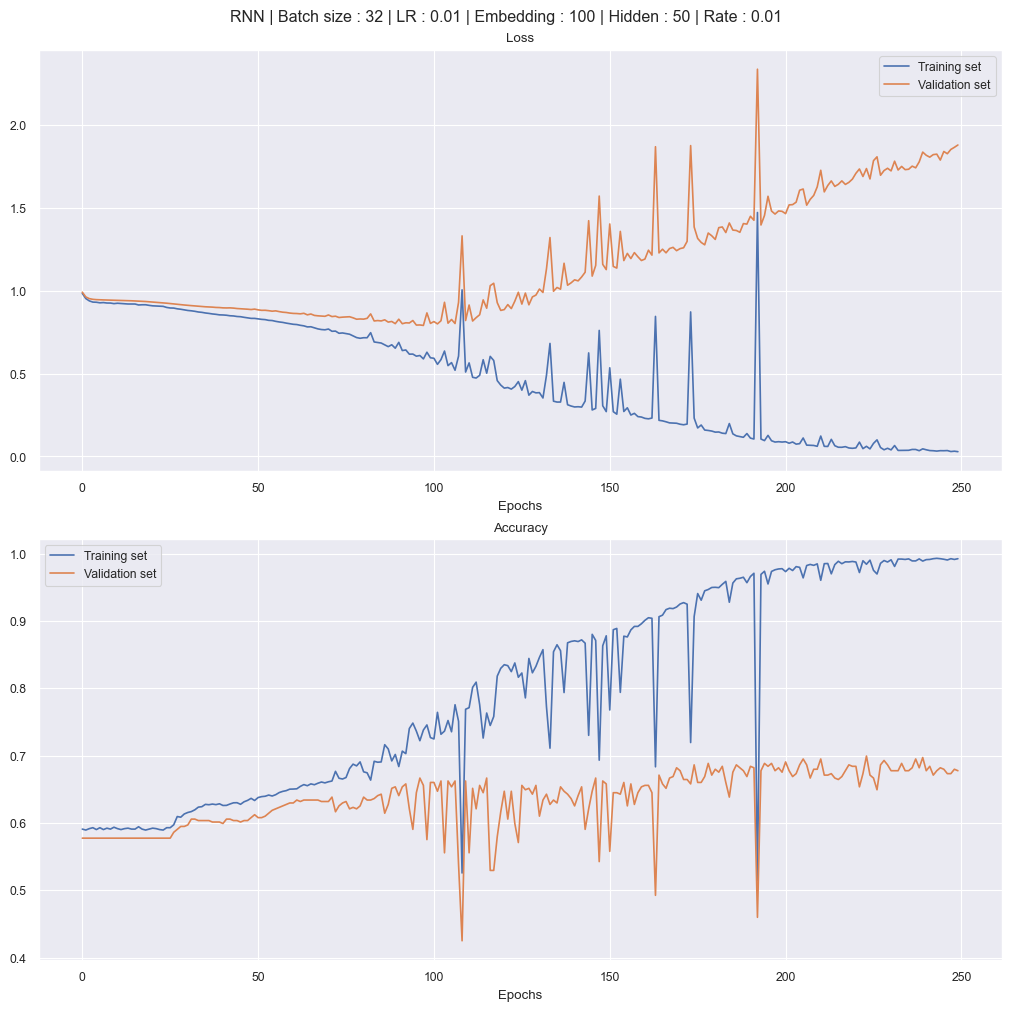

In [115]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =100
HIDDEN_DIM = 50
DROPOUT = 0.3
NB_LAYERS = 2

LEARNING_RATE = 1e-2
EPOCHS = 250
BATCH_SIZE = 32 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE)

100%|██████████| 150/150 [05:35<00:00,  2.24s/it]


'Test set accuracy: 0.674058'

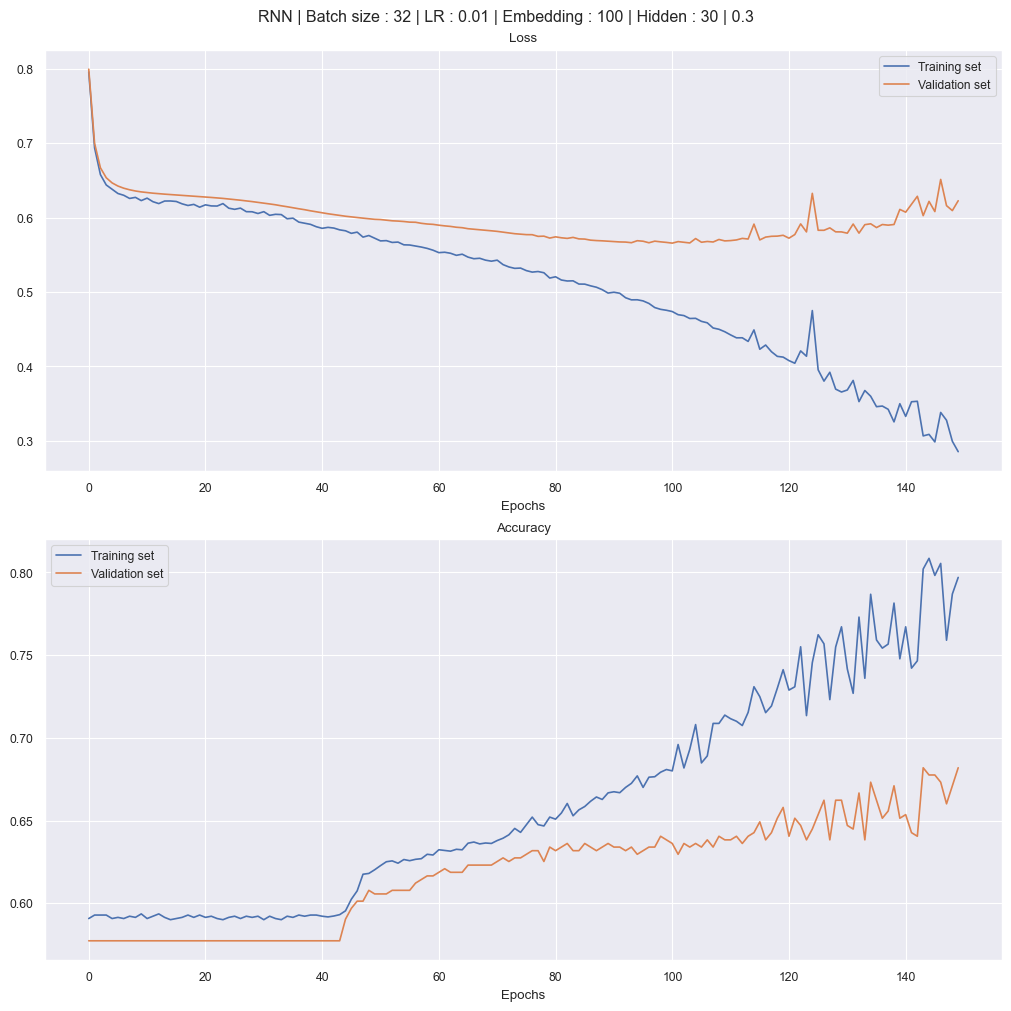

In [140]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =100
HIDDEN_DIM = 30
DROPOUT = 0.3
NB_LAYERS = 2

LEARNING_RATE = 1e-2
EPOCHS = 150
BATCH_SIZE = 32 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, DROPOUT=DROPOUT)

100%|██████████| 100/100 [03:40<00:00,  2.20s/it]


'Test set accuracy: 0.609756'

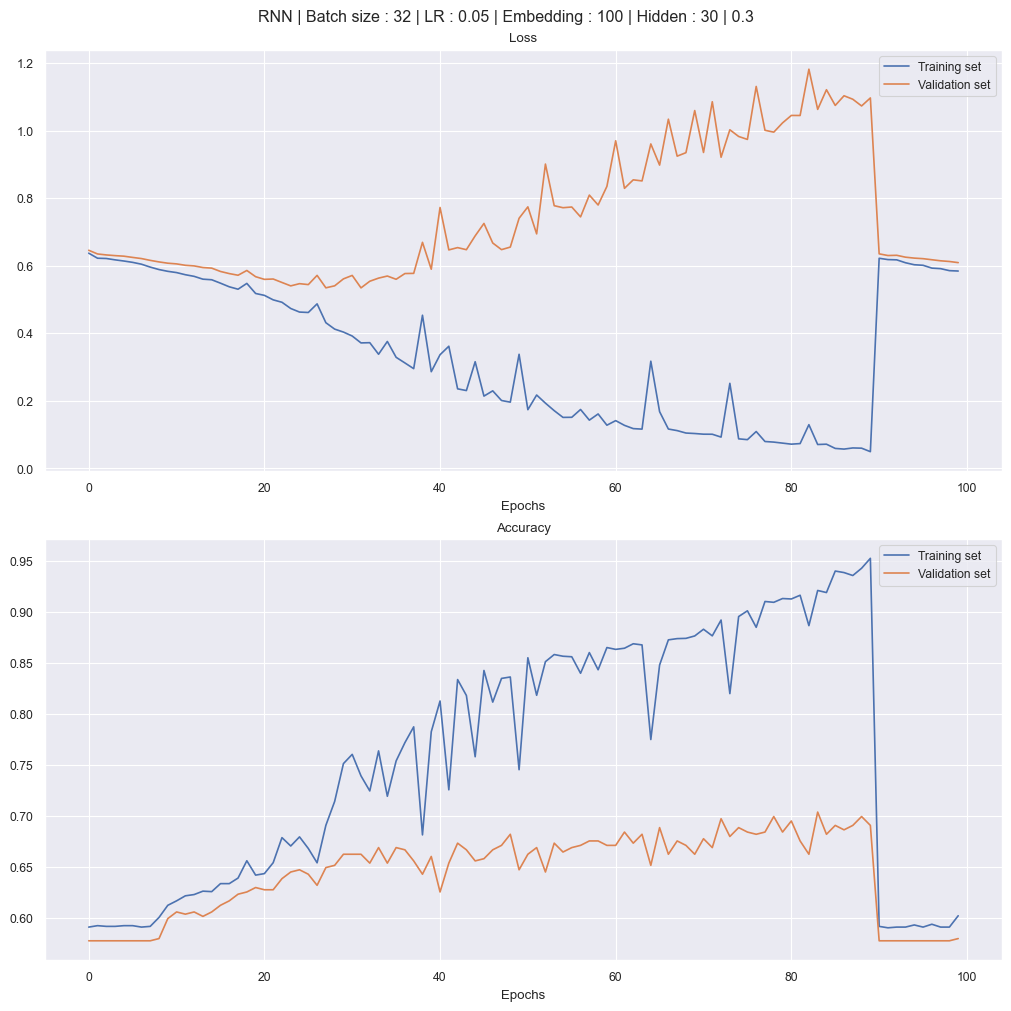

In [139]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =100
HIDDEN_DIM = 30
DROPOUT = 0.3
NB_LAYERS = 2

LEARNING_RATE = 5*1e-2
EPOCHS = 100
BATCH_SIZE = 32 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, DROPOUT=DROPOUT)

## Resampling Strategy